Plotting and annotation of core genome (Roary) analysis of Bbss data
- Assumes there is an roary output in results/ 

In [1]:
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ape))
suppressPackageStartupMessages(library(phytools))
suppressPackageStartupMessages(library(cowplot))
source("../scripts/Heatmap_PAM.R")
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library("ggpubr"))
suppressPackageStartupMessages(library(DECIPHER))
suppressPackageStartupMessages(library(forcats))
suppressPackageStartupMessages(library("DescTools"))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggfortify))
suppressPackageStartupMessages(library(beastio))

Warning message:
“package ‘ggfortify’ was built under R version 4.0.5”


In [2]:
# read in trees and midpoint root
x <- read.newick("../results/roary-results/core_gene_alignment.nwk")
x1 <- read.newick("../results/cfOUT_.labelled_tree.newick")
y <- read.newick("../results/OspC_Bbss_combined_4_24_2021.nwk")
z <- read.newick("../results/roary-results/split/core_gene_alignment_split.tree")
a <- read.newick("../results/roary-results/accessory_binary_genes.fa.newick")
x <- midpoint.root(x)
x1 <- midpoint.root(x1)
y <- midpoint.root(y)
z <- midpoint.root(z)
a <- midpoint.root(a)
# read in metadata
suppressMessages(metadata <- read_csv("../results/LymeSeq_SampleTrack - Renaming Scheme Table for Jupyter.2023-01-14.csv") %>% 
  mutate(RST_Type = factor(RST_Type)) %>%
  mutate(OspCK = ifelse(OspC_Type == "K", "K", "other")) %>% 
  mutate(OspCA = ifelse(OspC_Type == "A", 1, 0)) %>% 
  mutate(Region = recode(Location, Nantucket = "US Northeast", NY = "US Northeast",
                         RI = "US Northeast", CT = "US Northeast", WI = "US Midwest",
                         Slovenia = "EU Slovenia"
                        )) %>%
  mutate(Severity_Score = recode(Severity, mild = 0, moderate = 1, severe = 2)))
names(metadata)[1] <- "label"
metadata <- metadata %>%
  filter(label %in% x$tip.label)

# read in distances and infer clusters
d <- suppressWarnings(suppressMessages(data.frame(read_tsv("../results/kWIP-results/Bb.dist"))))
# clean up
rownames(d) <- d[,1]
d <- d[,-1]
d <- d[rownames(d) %in% metadata$label, colnames(d) %in% metadata$label]
#plot(cmdscale(d))
set.seed(1111)
clust <- kmeans(cmdscale(d), 3)$cluster %>%
  as.factor()
set.seed(1111)
clust2 <- kmeans(cmdscale(d), 4)$cluster %>%
  as.factor()
mds <- cmdscale(d) %>%
    as_tibble %>%
    mutate(groups = clust, label = rownames(cmdscale(d))) %>% 
    mutate(groups2 = clust2) %>%
    mutate(wgs_group = factor(recode(groups2, `1` = "A", `2`="B.2", `3`="B.1", `4`="C"))) %>%
    mutate(wgs_group = factor(wgs_group, levels(wgs_group)[c(1,3,2,4)])) %>% 
    mutate(WGS_Group = factor(recode(groups, `1` = "A", `2`="C", `3`="B"))) %>% 
    mutate(WGS_Group = factor(WGS_Group, levels(WGS_Group)[c(1,3,2)]))
# merge in MDS assignments to metadata
metadata_extended <- full_join(metadata, mds, by = "label")  %>% 
    mutate(dissem_bin = ifelse(Disseminated == "D", 1, 0)) %>% 
    mutate(Country = recode(Region, `US Northeast` = "US", `US Midwest` = "US", `EU Slovenia` = "Slovenia"))
metadata_extended <- data.frame(metadata_extended)

# Create basic trees
p <- suppressWarnings(ggtree(x))
p1 <- suppressWarnings(ggtree(y))

# Calculate proportions of RST and OspC types
print("RST Types")
table(metadata$RST_Type)/sum(table(metadata$RST_Type))
# Ensure that we have a full set of isolates
print("total number of isolates with RST typing")
sum(table(metadata[,5]))
print("OspC Types")
table(metadata$OspC_Type)/sum(table(metadata$OspC_Type))
print("total number of isolates with OspC typing")
sum(table(metadata$OspC_Type))

# Count numbers of OspC Types
table(metadata$OspC_Type)
sum(table(metadata$OspC_Type))

location_tree <- ggtree(x) %<+% metadata + 
  geom_tippoint(aes(color=Region, subset=!is.na(Location)), size = 4)
#location_tree
#ggsave("../results/figures/WGS_tree_annotated_with_Location.jpg")
loc_ospC <- ggtree(y) %<+% metadata + 
  geom_tippoint(aes(color=Region, subset=!is.na(Location)), size = 4)
#loc_ospC
#ggsave("../results/figures/OspC_tree_annotated_with_Location.jpg")
OspC_type_tree <- ggtree(x) %<+% metadata + 
  geom_tippoint(aes(color=OspC_Type, subset=!is.na(OspC_Type)), size = 4)
#OspC_type_tree

ospC_tree <- ggtree(y) %<+% metadata + 
  geom_tippoint(aes(color=OspC_Type, subset=!is.na(OspC_Type)), size = 4)
#ospC_tree

RST_type_tree <- ggtree(x) %<+% metadata + 
  geom_tippoint(aes(color=RST_Type, subset=!is.na(RST_Type)), size = 4)
#RST_type_tree

RST_ospC <- ggtree(y) %<+% metadata + 
  geom_tippoint(aes(color=RST_Type, subset=!is.na(RST_Type)), size = 4)
#RST_ospC

dissem_tree <- ggtree(x) %<+% metadata_extended + 
  geom_tippoint(aes(color=Disseminated, subset=!is.na(Disseminated)), size = 4, alpha = 0.6)
#dissem_tree

source_tree <- ggtree(x) %<+% metadata + 
  geom_tippoint(aes(color=Source, subset=!is.na(Source)), size = 4)
#source_tree

MEM_tree <- ggtree(x) %<+% metadata + 
  geom_tippoint(aes(color=`Multiple_EM(Y/N)`, subset=!is.na(`Multiple_EM(Y/N)`)), size = 4)
#MEM_tree

MLST_tree <- ggtree(x) %<+% metadata + 
  geom_tippoint(aes(color=MLST, subset=!is.na(MLST)), size = 4)
#MLST_tree

MLST_ospC <- ggtree(y) %<+% metadata + 
  geom_tippoint(aes(color=MLST, subset=!is.na(MLST)), size = 4)
#MLST_ospC
#plot_grid(location_tree, RST_type_tree, OspC_type_tree, MLST_tree, labels = c("A", "B", "C", "D"), nrow = 1)
#ggsave("../results/figures/annotated_trees_RST_OspC_MLST.jpg", width = 16, height = 12)

#plot_grid(loc_ospC, RST_ospC, ospC_tree, MLST_ospC, labels = c("A", "B", "C", "D"), nrow = 1)
#ggsave("../results/figures/OspC_tree_annotated_trees_RST_OspC_MLST.jpg", width = 16, height = 12)

#plot_grid(OspC_type_tree, ospC_tree, labels = c("A", "B"))
#ggsave("../results/figures/WGS_core_genome_vs_OspC_tree.jpg", width = 10, height = 12)
# Plot annotated trees with the WGS groups
wgs_tree <- ggtree(x) %<+% metadata_extended + 
  geom_tippoint(aes(color=WGS_Group, subset=!is.na(groups)), size = 4)

# Annotate trees with WGS groups
wgs_tree_split <- ggtree(z) %<+% metadata_extended + 
  geom_tippoint(aes(color=groups, subset=!is.na(groups)), size = 4)
#wgs_tree_split
#plot_grid(mds_plot, wgs_tree, wgs_tree_split, labels = c("A", "B", "C"),  nrow =1 )
#ggsave("../results/figures/genomic_groups.jpg", height = 6, width = 18)

wgs_tree_RST <- ggtree(x) %<+% metadata_extended + 
  geom_tippoint(aes(color=RST_Type), size = 2)
#wgs_tree_RST
#plot_grid(wgs_tree, wgs_tree_RST, labels = c("A", "B"))
#ggsave("../results/figures/WGS_group_vs_RST_Type.jpg", height = 5, width = 10)

ospc_tree <- ggtree(y) %<+% metadata_extended + 
  geom_tippoint(aes(color=groups, subset=!is.na(groups)), size = 4)
#ospc_tree
#ggsave("../figures/genomic_groups_ospC_tree.jpg")

# annotate tree with roary data and annotations
genotype <- suppressMessages(suppressWarnings(as.data.frame(read_csv("../results/roary-results/gene_presence_absence.csv"))))
rownames(genotype) <- genotype[,1]
genotype <- genotype[,-c(1:14)]
# convert to Rtab object
gene_mat <- mapply(function(x) ifelse(!is.na(x), 1, 0), genotype)
gene_mat <- data.frame(gene_mat)
gene_mat$Gene <- rownames(genotype)
# read in annotation from roary
annotation <- read.csv("../results/roary-results/gene_presence_absence.csv")
annotation <- annotation[,c(1,3)]
annotation$Gene_trunc <- gsub("group", "g", annotation$Gene)
annotation$Annotation <- gsub("hypothetical protein", "hyp", annotation$Annotation)

gt.annotated <- merge(annotation, gene_mat)
rownames(gt.annotated) <- paste(gt.annotated$Gene_trunc,":  ", gt.annotated$Annotation, sep="")
gt.annotated <- gt.annotated[,-c(1:3)]
# read in annotation from the Make_Manhattan.ipynb
annot <- suppressMessages(suppressWarnings(as_tibble(read_csv("../results/annotation/compiled_annotation.csv")))) %>% 
    mutate(Gene = Group) %>% select(-Group) %>% select(Gene,ID, Locus, B31_Annotation, Localization) %>% distinct()
gt.annot <- merge(annot, gene_mat)  #%>% filter(Localization == "S")
rownames(gt.annot) <- paste(gt.annot$Locus, gt.annot$B31_Annotation, gt.annot$Gene)
gt.annot <- gt.annot[,-c(1:5)]
# compute number of ORFS; might be nice to be able to plot these with a barplot next to the tree, but haven't figured out how to do this yet.
genome_length <- rowSums(t(gt.annotated))
genome_lengths <- data.frame(ORF_length = genome_length, label = colnames(gt.annotated))
metadata_extended <- left_join(metadata_extended, genome_lengths, by = "label")

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


[1] "RST Types"



        1         2         3 
0.3277592 0.3745819 0.2976589 

[1] "total number of isolates with RST typing"


[1] 299

[1] "OspC Types"



          A           B          B3           C           D           E 
0.147157191 0.153846154 0.006688963 0.013377926 0.023411371 0.030100334 
         E3           F          F3           G           H           I 
0.006688963 0.030100334 0.003344482 0.050167224 0.070234114 0.056856187 
          J           K           L           M           N           O 
0.010033445 0.173913043 0.050167224 0.023411371 0.073578595 0.013377926 
          Q           R           S           T           U 
0.006688963 0.010033445 0.010033445 0.013377926 0.023411371 

[1] "total number of isolates with OspC typing"


[1] 299


 A  B B3  C  D  E E3  F F3  G  H  I  J  K  L  M  N  O  Q  R  S  T  U 
44 46  2  4  7  9  2  9  1 15 21 17  3 52 15  7 22  4  2  3  3  4  7 

[1] 299

In [3]:
x2 <- read.tree("../results/RAxML_bestTree.raxOUT.nwk")
x2 <- midpoint.root(x2)

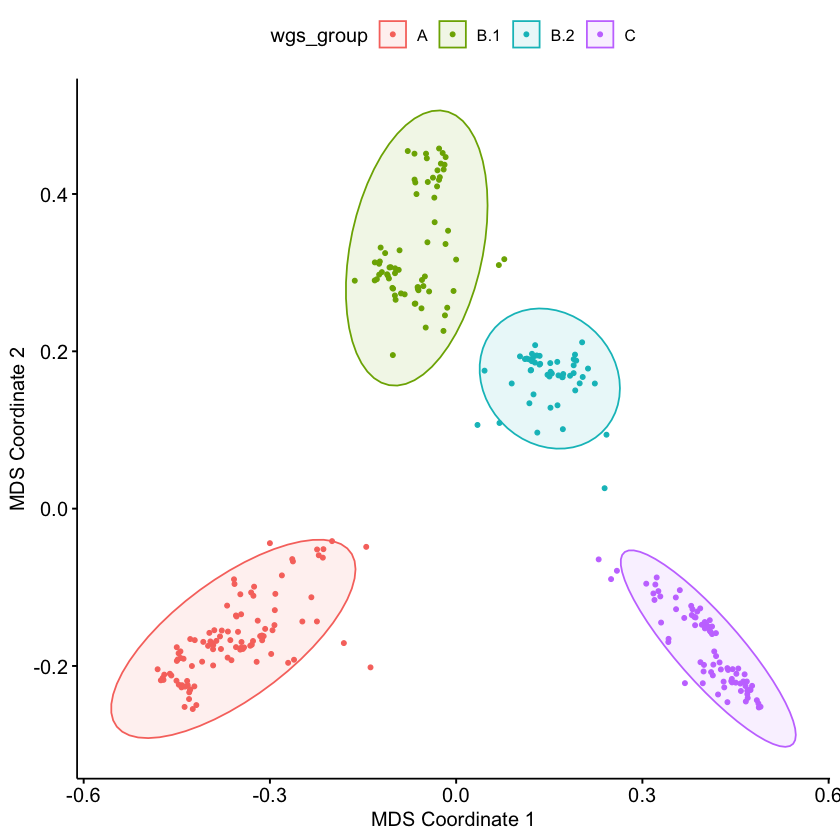

In [4]:
mds_plot2 <- ggscatter(mds, x = "V1", y = "V2", 
          #label = rownames(d),
          color = "wgs_group",
          size = 1, 
          ellipse = TRUE,
          #ellipse.type = "convex",
          repel = TRUE) + labs(x = "MDS Coordinate 1", y = "MDS Coordinate 2")
mds_plot2

In [5]:
#aln <- readDNAStringSet("../results/roary-results/core_gene_alignment.aln")
#dist_mat <- DistanceMatrix(aln)

distance matrix of aligned sequences did not work well. 
- possibly phylogenetic distance is not well approximated by edit distance given the extent of divergence
- scaling is non-metric? In any event, the MDS looks bad.

Use Weihau's kWIP distance instead

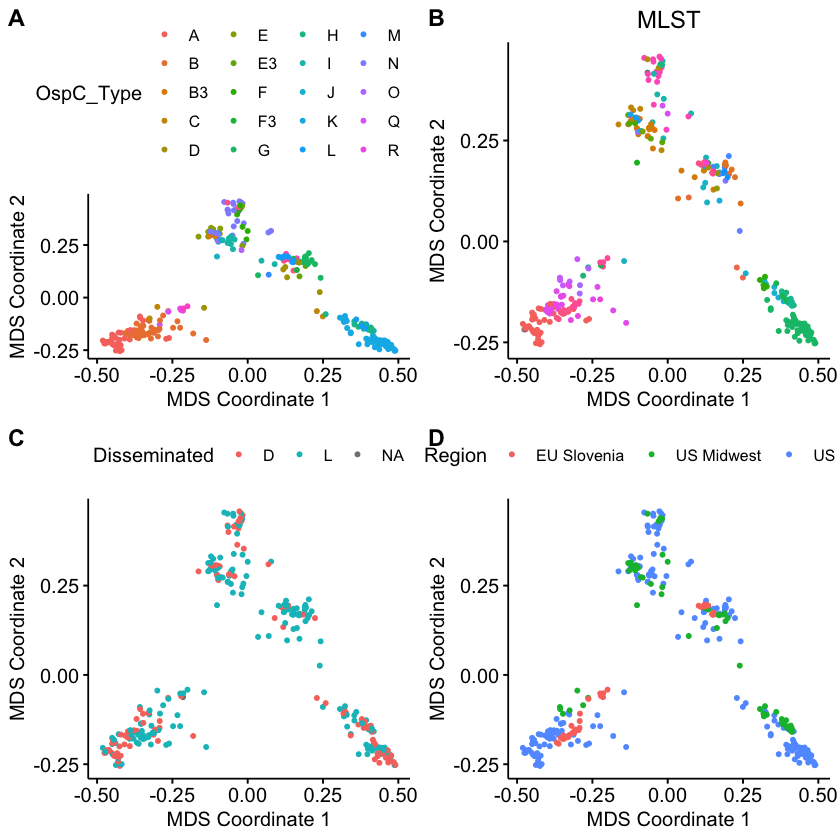

In [6]:
## Generate MDS plots annotated with metadata

mds_OspC <- ggscatter(metadata_extended %>% filter(!is.na(OspC_Type)), x = "V1", y = "V2", 
          #label = rownames(d),
          color = "OspC_Type",
          size = 1, 
          repel = TRUE) + labs(x = "MDS Coordinate 1", y = "MDS Coordinate 2")

mds_MLST <- ggscatter(metadata_extended %>% filter(!is.na(OspC_Type)), x = "V1", y = "V2", 
          #label = rownames(d),
          color = "MLST",
          size = 1, 
          repel = TRUE) + labs(x = "MDS Coordinate 1", y = "MDS Coordinate 2", title = "MLST") + 
          theme(plot.title = element_text(hjust = 0.5)) +
          theme(legend.position = "none")
#ggsave("../results/figures/MDS_OspC.jpg", height = 4, width = 4)
dissem_data <- ggscatter(metadata_extended, x = "V1", y = "V2", 
          #label = rownames(d),
          color = "Disseminated",
          size = 1, 
          repel = TRUE) + labs(x = "MDS Coordinate 1", y = "MDS Coordinate 2")

loc_data <- ggscatter(metadata_extended, x = "V1", y = "V2", 
          #label = rownames(d),
          color = "Region",
          size = 1, 
          repel = TRUE) + labs(x = "MDS Coordinate 1", y = "MDS Coordinate 2")
plot_grid(mds_OspC, mds_MLST, dissem_data, loc_data, labels = c("A", "B", "C", "D"))
#ggsave("../results/figures/paper/Figure_S1.jpg", height = 10, width = 10)

In [7]:
# Create core + accessory genome PAM
upper_threshold = 30 # remove from plotting anything in more than N - upper_threshold of the isolates, i.e. plot only ORFs in 90+ % of isolates
lower_threshold = 10 # remove from plotting anything in less than lower_threshold of isolates
genotype.trunc <- gt.annotated[rowSums(gt.annotated)> lower_threshold & (rowSums(gt.annotated) < (ncol(gt.annotated)-upper_threshold)),]
p_hm <- suppressWarnings(heatMapPAM(wgs_tree,t(genotype.trunc), colnames=FALSE, col_colours="blue", colnames_angle = -90,hjust =1, width=2, font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-50, border_colour=NULL))
ggsave("../results/figures/core_genome_clusters.2022-07-18.jpg", height = 8, width = 10)

wgs_tree_reg <- ggtree(x) %<+% metadata + geom_tippoint(aes(color = Region))
p_hm_reg <- heatMapPAM(wgs_tree_reg,t(genotype.trunc), colnames=FALSE, col_colours="blue", colnames_angle = -90,hjust =1, width=2, font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-50, border_colour=NULL)
#ggsave("../results/figures/core_genome_clusters_region.2022-07-18.jpg", height = 8, width = 10)

wgs_tree_ospc <- ggtree(x) %<+% metadata + geom_tippoint(aes(color = OspC_Type), size = 2)
p_hm_ospc <- heatMapPAM(wgs_tree_ospc,t(genotype.trunc), colnames=FALSE, col_colours="blue", colnames_angle = -90,
                        hjust =1, width=7, font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-50, border_colour=NULL)
ggsave("../results/figures/paper/Figure_5A.jpg", height = 4.5, width = 8)

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


The following object is masked from ‘package:ggtree’:

    inset




In [8]:
# Create core + accessory lipoproteome PAM
upper_threshold = 20 # remove from plotting anything in more than N - upper_threshold of the isolates, i.e. plot only ORFs in 90+ % of isolates
lower_threshold = 10 # remove from plotting anything in less than lower_threshold of isolates
genotype.trunc2 <- gt.annot[rowSums(gt.annot)> lower_threshold & (rowSums(gt.annot) < (ncol(gt.annotated)-upper_threshold)),]

p_hm2 <- heatMapPAM(wgs_tree_ospc,t(genotype.trunc2), colnames=TRUE, col_colours="blue", 
                    colnames_angle = 90,hjust =0, width=35, font.size=5, cluster_cols=TRUE, 
                    null_colour="white",colnames_offset_y=-20, border_colour=NULL,
                   colnames_position = "bottom")
#ggsave("../results/figures/core_genome_clusters_annotation2.pdf", height = 100, width = 200, limitsize=FALSE)
p_hm2 <- heatMapPAM(wgs_tree_reg,t(genotype.trunc2), colnames=TRUE, col_colours="blue", 
                    colnames_angle = 90,hjust =0, width=35, font.size=5, cluster_cols=TRUE, 
                    null_colour="white",colnames_offset_y=-20, border_colour=NULL,
                   colnames_position = "bottom")
#ggsave("../results/figures/core_genome_clusters_annotation_region2.pdf", height = 100, width = 200, limitsize=FALSE)

#suppressMessages(suppressWarnings(p_hm2b))
ggsave("../results/figures/paper/Figure_6A.jpg", height = 10, width = 10, limitsize=FALSE)

In [11]:
# Create plasmids PAM
plasmids <- suppressMessages(data.frame(read_tsv("../plasmid_types_v3.tsv")))
rownames(plasmids) <- plasmids[,1]
plasmids <- plasmids[,-c(1)]

names(plasmids) <- sapply(names(plasmids), function(x) tail(strsplit(x, "_")[[1]], 1))
names(plasmids) <- gsub("ID.23.B31", "", names(plasmids))
plasmids[is.na(plasmids)] <- 0
p_plas <- heatMapPAM(location_tree,plasmids, col_colours="blue", colnames_angle = -90,hjust =1, width=2, font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-50, border_colour=NULL)
ggsave("../results/figures/core_genome_plasmids_location.jpg", height = 12, width = 20)
# make sure you edit plasmids tsv file to replace | with _ so the columns read in correctly!
p_plas <- heatMapPAM(location_tree,plasmids, col_colours="blue", colnames_angle = -90,hjust =1, width=2, font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-50, border_colour=NULL)
ggsave("../results/figures/core_genome_plasmids_location.jpg", height = 12, width = 20)

p_plas2 <- heatMapPAM(wgs_tree,plasmids, col_colours="blue", colnames_angle = -90,hjust =1, width=2, font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-50, border_colour=NULL)
ggsave("../results/figures/core_genome_plasmids_wgs_group.jpg", height = 12, width = 20)

p_plas3 <- heatMapPAM(RST_type_tree,plasmids, col_colours="blue", colnames_angle = -90,hjust =1, width=2, font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-50, border_colour=NULL)
ggsave("../results/figures/core_genome_plasmids_RST.jpg", height = 12, width = 20)

p_plas4 <- heatMapPAMplas(OspC_type_tree,plasmids, col_colours="blue", colnames_angle = -90,hjust =1, width=10, 
                      font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-40, border_colour=NULL)
ggsave("../results/figures/paper/Figure_4A.jpg", height = 5, width = 8)


In [9]:
plas2 <- suppressMessages(data.frame(read_tsv("../plasmid_alignment_ref.tsv")))
rownames(plas2) <- plas2$Replicon
plas2 <- t(plas2[,-c(300:301)]) # replicon and length column removal is hard coded
colnames(plas2)[1] <- "Chrom"
p_plas5 <- heatMapPAMplas(OspC_type_tree,plas2, col_colours="blue", colnames_angle = -90,hjust =1, width=10, 
                      font.size=4, cluster_cols=TRUE, null_colour="white",colnames_offset_y=-40, border_colour=NULL)
ggsave("../results/figures/paper/Figure_S5.jpg", height = 5, width = 8)

In [10]:
## Calculate associations between covariates
fisher.test(metadata_extended$WGS_Group, metadata_extended$Region) #, simulate.p.value = TRUE, B = 1e6)

#fisher.test(metadata_extended$Disseminated, metadata_extended$WGS_Group, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata_extended$RST_Type, metadata_extended$group, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata_extended$group, metadata_extended$OspC_Type, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata_extended$group, metadata_extended$Location, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata_extended$group, metadata_extended$Region, simulate.p.value = TRUE, B = 1e6)


	Fisher's Exact Test for Count Data

data:  metadata_extended$WGS_Group and metadata_extended$Region
p-value = 1.605e-09
alternative hypothesis: two.sided


In [11]:
pSevere <- ggplot(metadata_extended, aes(x =groups, y = Severity_Score)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "red"
   ) +
    stat_summary(fun.data = mean_se,
                 geom = "errorbar", color = "red",
                width = 0.25) + 
theme_bw() + 
labs(x = "WGS Group", y = "Severity")
#plot_grid(pDissem, pSevere, labels = c("A", "B"), nrow = 1)
#ggsave("../results/figures/probability_of_dissemination_by_group.jpg", height = 5, width = 10)

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


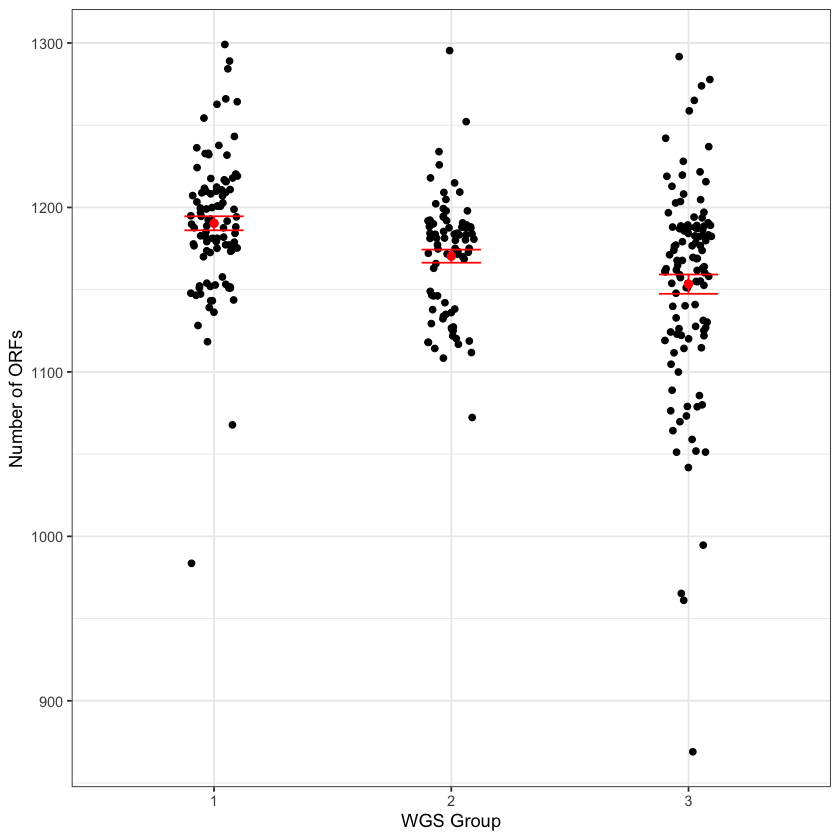

In [14]:
pGLength <- suppressWarnings(suppressMessages(ggplot(metadata_extended, aes(x =groups, y = ORF_length)) + geom_jitter(width = 0.1) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "red"
   ) +
    stat_summary(fun.data = mean_se,
                 geom = "errorbar", color = "red",
                width = 0.25) + 

theme_bw() + 
labs(x = "WGS Group", y = "Number of ORFs")))
suppressMessages(suppressWarnings(pGLength))
suppressWarnings(ggsave("../results/figures/Genome_size_by_group.jpg", height = 5, width = 5))

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.ymin` is deprecated. Use `fun.min` instead.”
Warning message:
“`fun.ymax` is deprecated. Use `fun.max` instead.”
Warning message in wilcox.test.default(c(1184, 1151, 1203, 1174, 984, 1068, 1173:
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1130, 1242, 1162, 1177, 1115, 1131, 1127, :
“cannot compute exact p-value with ties”
Warning message:
“Computation failed in `stat_signif()`:
not enough 'y' observations”
Warning message in wilcox.test.default(c(1173, 1153, 1144, 1175, 1181, 1153, 1128, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1184, 1151, 1203, 1174, 984, 1068, 1173:
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1173, 1153, 1144, 1175, 1181, 1153, 1128, :
“cannot compute exact p-value with ties”
Warning message:
“Computation fa

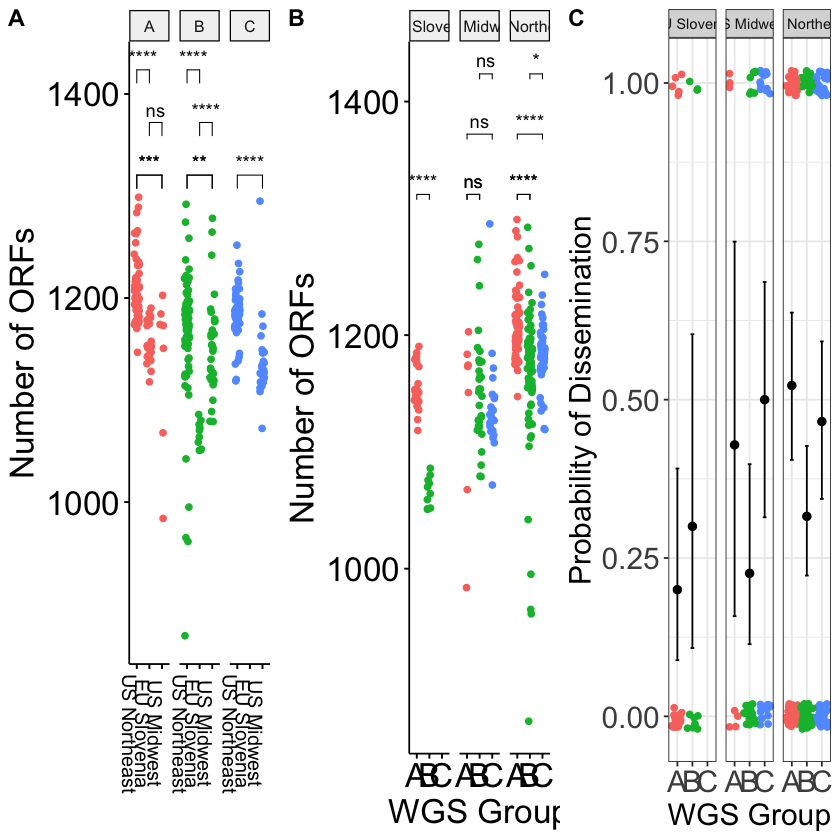

In [79]:
## Figure 3
pDissem <- ggplot(metadata_extended %>% filter(!is.na(Country)), aes(x =WGS_Group, y = dissem_bin, color = WGS_Group)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "black"
   ) +
    stat_summary(fun.y = function(x) BinomCI(sum(x), length(x))[1], 
                 fun.ymin = function(x) BinomCI(sum(x), length(x))[2],
                 fun.ymax = function(x) BinomCI(sum(x), length(x))[3],
                 geom = "errorbar", color = "black",
                width = 0.25) + 
theme_bw() + 
labs(x = "WGS Group", y = "Probability of Dissemination") + 
facet_grid(~Region) + 
theme(legend.position = "none", axis.text=element_text(size = 18), axis.title=element_text(size = 18))
#pDissem

dissem_tree <- ggtree(x) %<+% metadata_extended + 
  geom_tippoint(aes(color=Disseminated, subset=!is.na(Disseminated)), size = 2, alpha = 0.6) + 
    scale_color_discrete(labels = c("Disseminated", "Localized"), name = "") + 
    theme(legend.position = "left", legend.text=element_text(size=18))
#dissem_tree


my_comparisons = list( c("A","B"),c("A", "C"), c("B", "C"))
my_comparisons3 = list(c("A", "B"))
ORF_group <- metadata_extended %>% filter(!is.na(Country)) %>% 
    ggstripchart(x = "WGS_Group", y = "ORF_length", add="jitter", 
                                color = "WGS_Group",
                                add.params = list(size = 0.5, alpha =0.5)) + 
    #stat_compare_means(label = "p.signif", label.x=2) + 
    stat_compare_means(comparisons = my_comparisons3, label = "p.signif", tip.length = 0.01) + 
    labs(x = "WGS Group", y = "Number of ORFs") + 
    font("xlab", size = 20) + font("ylab", size = 20) + font("xy.text", size = 20)  + 
    facet_grid(~Region) + 
    stat_compare_means(comparisons = my_comparisons, label = "p.signif", tip.length = 0.01) + 
    theme(legend.position = "none")
my_comparisons2 = list(c("US Midwest", "US Northeast"),c("US Midwest","EU Slovenia"), c("US Northeast", "EU Slovenia"))
my_comparisons4 = list(c("US Midwest", "US Northeast"))
ORF_region <- metadata_extended %>% 
mutate(Country = recode(Region, Slovenia = "EU")) %>%filter(!is.na(Country)) %>% ggstripchart(x = "Country", y = "ORF_length", add="jitter", 
                                color = "WGS_Group",
                                add.params = list(size = 0.5, alpha =0.5)) + 
    #stat_compare_means(label = "p.signif", label.x=2) + 
    labs(x = "", y = "Number of ORFs") + 
    font("xlab", size = 20) + font("ylab", size = 20) + font("xy.text", size = 20)  + 
    facet_grid(~WGS_Group) + 
    stat_compare_means(comparisons = my_comparisons2, label = "p.signif") + 
    stat_compare_means(comparisons = my_comparisons4, label = "p.signif") + 
    theme(axis.text.x = element_text(angle = -90, size = 12), legend.position = "none")

#ORF_region
plot_grid( ORF_region,ORF_group, pDissem, labels = c("A", "B", "C"), nrow = 1)#, rel_widths = c(2,1.2,2))
ggsave("../results/figures/paper/Figure_3.jpg", height = 5, width = 12)

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.ymin` is deprecated. Use `fun.min` instead.”
Warning message:
“`fun.ymax` is deprecated. Use `fun.max` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.ymin` is deprecated. Use `fun.min` instead.”
Warning message:
“`fun.ymax` is deprecated. Use `fun.max` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.ymin` is deprecated. Use `fun.min` instead.”
Warning message:
“`fun.ymax` is deprecated. Use `fun.max` instead.”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_poi

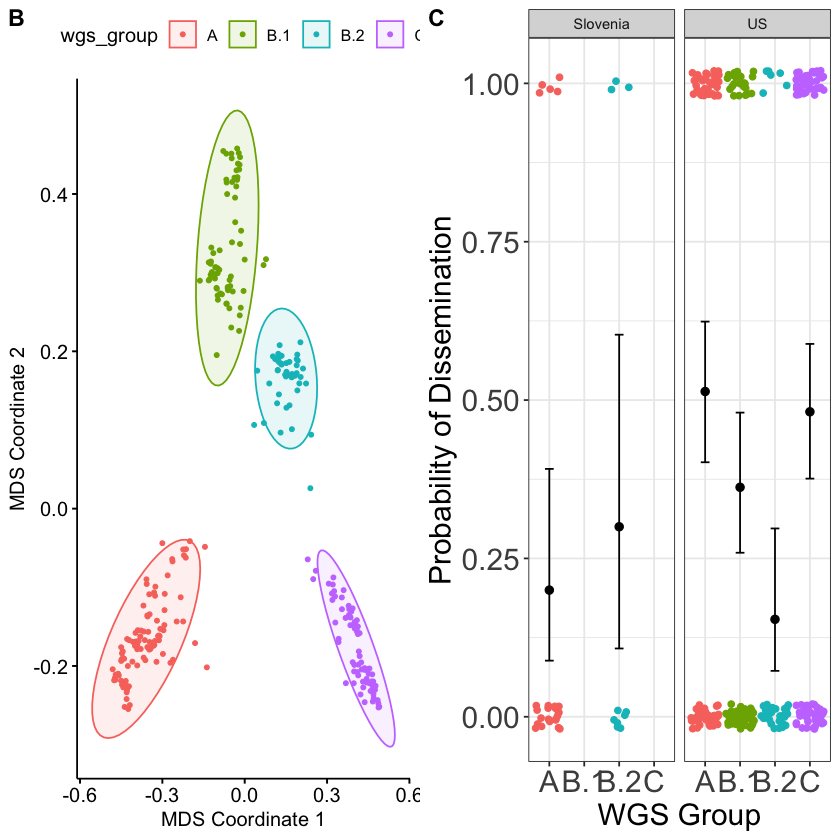

In [41]:
pDissem2 <- ggplot(metadata_extended %>% filter(!is.na(Country)), aes(x =wgs_group, y = dissem_bin, color = wgs_group)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "black"
   ) +
    stat_summary(fun.y = function(x) BinomCI(sum(x), length(x))[1], 
                 fun.ymin = function(x) BinomCI(sum(x), length(x))[2],
                 fun.ymax = function(x) BinomCI(sum(x), length(x))[3],
                 geom = "errorbar", color = "black",
                width = 0.25) + 
theme_bw() + 
labs(x = "WGS Group", y = "Probability of Dissemination") + 
facet_grid(~Country) + 
theme(legend.position = "none", axis.text=element_text(size = 18), axis.title=element_text(size = 18))



pDissem2.1 <- ggplot(metadata_extended %>% filter(!is.na(Country)), aes(x =WGS_Group, y = dissem_bin, color = wgs_group)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "black"
   ) +
    stat_summary(fun.y = function(x) BinomCI(sum(x), length(x))[1], 
                 fun.ymin = function(x) BinomCI(sum(x), length(x))[2],
                 fun.ymax = function(x) BinomCI(sum(x), length(x))[3],
                 geom = "errorbar", color = "black",
                width = 0.25) + 
theme_bw() + 
labs(x = "WGS Group", y = "Probability of Dissemination") + 
facet_grid(~Region) + 
theme(legend.position = "none", axis.text=element_text(size = 18), axis.title=element_text(size = 18))

pDissem2.2 <- ggplot(metadata_extended %>% filter(!is.na(Country)), aes(x =wgs_group, y = dissem_bin, color = wgs_group)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "black"
   ) +
    stat_summary(fun.y = function(x) BinomCI(sum(x), length(x))[1], 
                 fun.ymin = function(x) BinomCI(sum(x), length(x))[2],
                 fun.ymax = function(x) BinomCI(sum(x), length(x))[3],
                 geom = "errorbar", color = "black",
                width = 0.25) + 
theme_bw() + 
labs(x = "WGS Group", y = "Probability of Dissemination") + 
facet_grid(~Region) + 
theme(legend.position = "none", axis.text=element_text(size = 18), axis.title=element_text(size = 18))

my_comparisons = list(c("a","c"))#, c("B","C"), c("A", "C"))
my_comparisons3 = list(c("a","c"))
ORF_group <- metadata_extended %>% filter(!is.na(Country)) %>% ggstripchart(x = "wgs_group", y = "ORF_length", add="jitter", 
                                color = "wgs_group",
                                add.params = list(size = 0.5, alpha =0.5)) + 
    #stat_compare_means(label = "p.signif", label.x=2) + 
    stat_compare_means(comparisons = my_comparisons, label = "p.signif") + 
    stat_compare_means(comparisons = my_comparisons3, label = "p.signif") + 
    labs(x = "WGS Group", y = "Number of ORFs") + 
    font("xlab", size = 20) + font("ylab", size = 20) + font("xy.text", size = 20)  + 
    facet_grid(~Country)
my_comparisons2 = list(c("US","Slovenia"))
ORF_region <- metadata_extended %>% filter(!is.na(Country)) %>% ggstripchart(x = "Country", y = "ORF_length", add="jitter", 
                                color = "wgs_group",
                                add.params = list(size = 0.5, alpha =0.5)) + 
    #stat_compare_means(label = "p.signif", label.x=2) + 
    stat_compare_means(comparisons = my_comparisons2, label = "p.signif") + 
    labs(x = "", y = "Number of ORFs") + 
    font("xlab", size = 20) + font("ylab", size = 20) + font("xy.text", size = 20)  + 
    facet_grid(~wgs_group)
#ORF_region
p_hm2b <- heatMapPAM(wgs2_tree,t(genotype.trunc2), colnames=FALSE, col_colours="blue", 
                    colnames_angle = 90,hjust =0, width=10, font.size=5, cluster_cols=TRUE, 
                    null_colour="white",colnames_offset_y=-20, border_colour=NULL,
                   colnames_position = "bottom")
ggsave("../results/figures/paper/Figure_S3A.jpg", height = 5, width = 10)
plot_grid(mds_plot2, pDissem2, labels = c("B", "C"),nrow=1)
ggsave("../results/figures/paper/Figure_S3B-E.jpg",height = 5, width = 10)

In [ ]:
pDissem3 <- ggplot(metadata_extended %>% filter(!is.na(Country)), aes(x =Country, y = dissem_bin)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "black"
   ) +
    stat_summary(fun.y = function(x) BinomCI(sum(x), length(x))[1], 
                 fun.ymin = function(x) BinomCI(sum(x), length(x))[2],
                 fun.ymax = function(x) BinomCI(sum(x), length(x))[3],
                 geom = "errorbar", color = "black",
                width = 0.25) + 
theme_bw() + 
labs(x = "WGS Group", y = "Probability of Dissemination") + 
theme(legend.position = "none", axis.text=element_text(size = 18), axis.title=element_text(size = 18))
pDissem3
fisher.test(metadata_extended$Disseminated, metadata_extended$Country, simulate.p.value = TRUE, B = 1e6)

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.ymin` is deprecated. Use `fun.min` instead.”
Warning message:
“`fun.ymax` is deprecated. Use `fun.max` instead.”



	Fisher's Exact Test for Count Data with simulated p-value (based on
	1e+06 replicates)

data:  metadata_extended$Disseminated and metadata_extended$OspC_Type
p-value = 0.1461
alternative hypothesis: two.sided


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.ymin` is deprecated. Use `fun.min` instead.”
Warning message:
“`fun.ymax` is deprecated. Use `fun.max` instead.”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”



	Fisher's Exact Test for Count Data with simulated p-value (based on
	1e+06 replicates)

data:  metadata_extended$Disseminated and metadata_extended$RST_Type
p-value = 0.003966
alternative hypothesis: two.sided


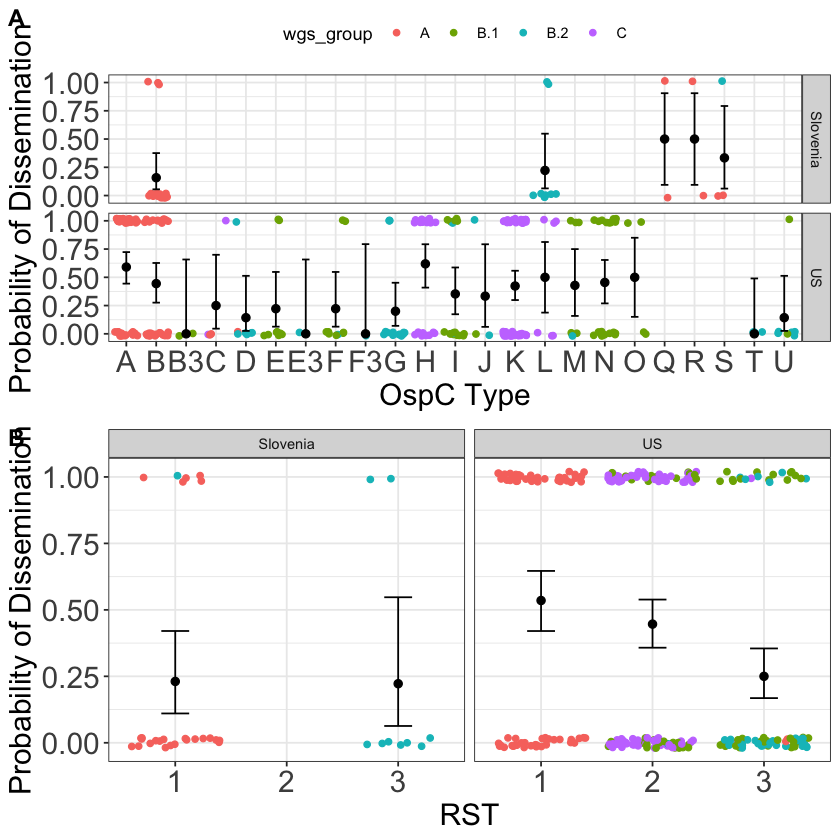

In [26]:
pDissem4 <- ggplot(metadata_extended %>% filter(!is.na(OspC_Type)), aes(x =OspC_Type, y = dissem_bin, color=wgs_group)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "black"
   ) +
    stat_summary(fun.y = function(x) BinomCI(sum(x), length(x))[1], 
                 fun.ymin = function(x) BinomCI(sum(x), length(x))[2],
                 fun.ymax = function(x) BinomCI(sum(x), length(x))[3],
                 geom = "errorbar", color = "black",
                width = 0.25) + 
theme_bw() + 
labs(x = "OspC Type", y = "Probability of Dissemination") + 
theme(legend.position = "top", axis.text=element_text(size = 18), axis.title=element_text(size = 18)) + 
facet_grid(rows=vars(Country))
fisher.test(metadata_extended$Disseminated, metadata_extended$OspC_Type, simulate.p.value = TRUE, B = 1e6)

pDissem5 <- ggplot(metadata_extended %>% filter(!is.na(OspC_Type)), aes(x =RST_Type, y = dissem_bin, color=wgs_group)) + geom_jitter(height = 0.02) + 
 stat_summary(
    fun.y = mean,
    geom = "point",
    size = 2,
    color = "black"
   ) +
    stat_summary(fun.y = function(x) BinomCI(sum(x), length(x))[1], 
                 fun.ymin = function(x) BinomCI(sum(x), length(x))[2],
                 fun.ymax = function(x) BinomCI(sum(x), length(x))[3],
                 geom = "errorbar", color = "black",
                width = 0.25) + 
theme_bw() + 
labs(x = "RST", y = "Probability of Dissemination") + 
theme(legend.position = "none", axis.text=element_text(size = 18), axis.title=element_text(size = 18)) +
facet_grid(~Country)

plot_grid(pDissem4, pDissem5, labels = c("A", "B"), nrow = 2)
fisher.test(metadata_extended$Disseminated, metadata_extended$RST_Type, simulate.p.value = TRUE, B = 1e6)
ggsave("../results/figures/paper/Figure_S4.jpg",height = 8, width = 8)

In [ ]:
## Generate accessory genome with presence/absence heatmap 

accessory_tree <- ggtree(a) %<+% metadata_extended + 
  geom_tippoint(aes(color=wgs_group, subset=!is.na(wgs_group)), size = 2)
accessory_tree

p_hm_ac <- heatMapPAM(accessory_tree,t(genotype.trunc2), colnames=FALSE, col_colours="blue", 
                    colnames_angle = 90,hjust =0, width=10, font.size=5, cluster_cols=TRUE, 
                    null_colour="white",colnames_offset_y=-20, border_colour=NULL,
                   colnames_position = "bottom", presence_label = "ORF Present", absence_label = "ORF Absent") 
ggsave("../results/figures/paper/Figure_S4A.jpg", height = 5, width = 6)

p_hm_ac_p <- heatMapPAM(accessory_tree,plasmids,, col_colours="blue", colnames_angle = -90,
                        hjust =1, width=10, font.size=2, cluster_cols=TRUE, 
                        null_colour="white",colnames_offset_y=-65, border_colour=NULL,
                       presence_label = "PF-32 Present", absence_label = "PF-32 Absent")
ggsave("../results/figures/paper/Figure_S4B.jpg", height = 5, width = 6)



In [ ]:
my_comparisons4 = list(c("D","L"))
metadata_extended %>% filter(!is.na(Disseminated)) %>% ggstripchart(x = "Disseminated", y = "ORF_length", add="jitter", 
                                add.params = list(size = 0.5, alpha =0.5)) + 
    #stat_compare_means(label = "p.signif", label.x=2) + 
    stat_compare_means(comparisons = my_comparisons4, label = "p.signif") + 
    labs(x = "", y = "Number of ORFs") + 
    font("xlab", size = 20) + font("ylab", size = 20) + font("xy.text", size = 20)  + 
    facet_grid(~Country)


In [ ]:
metadata_extended %>% filter(!is.na(Region)) %>% ggstripchart(x = "WGS_Group", y = "dissem_bin", 
                                color = "Region",
                                add.params = list(size = 0.5, alpha =0.5)) + 
    #stat_compare_means(label = "p.signif", label.x=2) + 
    stat_compare_means(comparisons = my_comparisons, label = "p.signif") + 
    labs(x = "WGS Group", y = "Number of ORFs") + 
    font("xlab", size = 20) + font("ylab", size = 20) + font("xy.text", size = 20)  


In [ ]:
model_df <- metadata_extended %>% 
filter(ORF_length > 1100) %>% 
filter(ORF_length < 1250)
m1 <- glm(dissem_bin ~ ORF_length, model_df, family = binomial)
summary(m1)
metadata_extended %>% 
filter(ORF_length > 1100) %>% 
filter(ORF_length < 1250) %>%
ggplot(aes(x = ORF_length, y = dissem_bin)) + geom_jitter(height = 0.05) + 
stat_smooth(method="glm", se=TRUE, method.args = list(family=binomial)) + theme_bw() + labs(y = "Probability of Dissemination")
ggplot(metadata_extended %>% filter(!is.na(Severity_Score)), aes(x = ORF_length, y = Severity_Score)) + 
  geom_point() + 
  stat_smooth(method = "lm") + 
  theme_bw()

In [ ]:
# analysis by fine-grain geography
NE_samples <- metadata_extended %>% filter(Region == "US Northeast")

In [ ]:
fisher.test(NE_samples$WGS_Group, NE_samples$Location, simulate.p.value = TRUE, B = 1e6)

what about measures of genome length?
- is size of accessory genome correlated with phylogeny? 
- with severity?

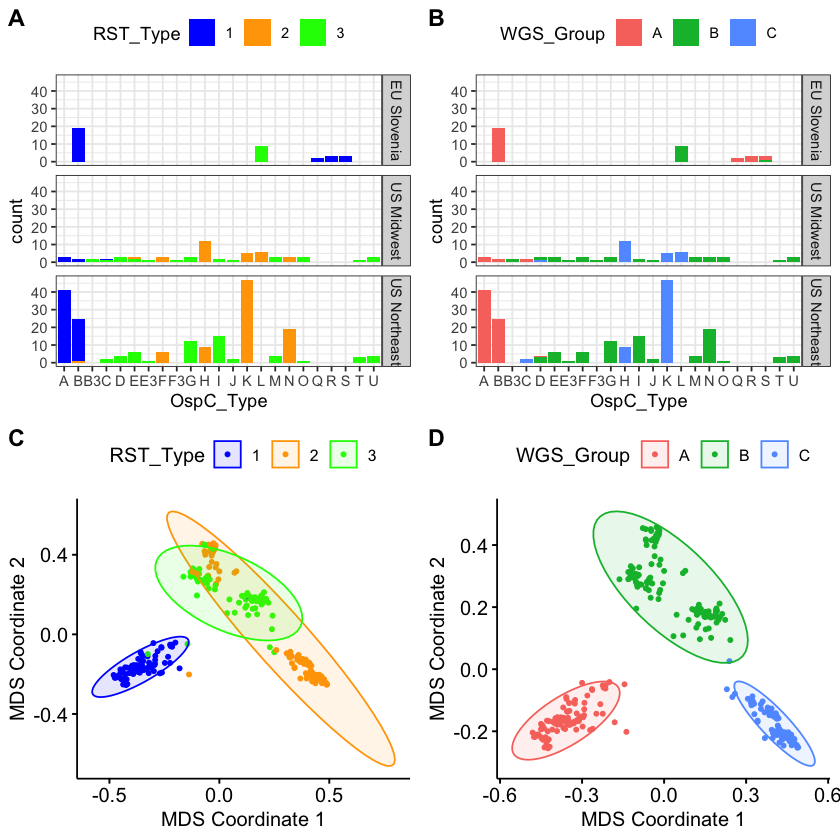

In [17]:
## Figure 1

# calculate associations between metadata variables
#ggpairs(metadata_extended %>% filter(c(OspC_Type, RST_Type, groups)), cardinality_threshold = 25)
#ggsave("../results/figures/OspC_Type_vs_RST_pairs.jpg")
pA <- metadata %>% 
    filter(!is.na(RST_Type)) %>% 
    ggplot(aes(x = OspC_Type, fill=RST_Type)) + geom_bar() + facet_grid(rows = vars(Region)) +
    theme_bw() +
    theme(legend.position="top")+
    scale_fill_manual(values = c("blue", "orange", "green"))

pB <- metadata_extended %>% 
    filter(!is.na(RST_Type)) %>% 
    ggplot(aes(x = OspC_Type, fill=WGS_Group)) + geom_bar() + facet_grid(rows = vars(Region)) + 
    theme_bw() + 
    theme(legend.position = "top") 
#plot_grid(pA, pB, labels = c("A", "B"))

# Plot and color by groups
mds_plot <- ggscatter(mds, x = "V1", y = "V2", 
          #label = rownames(d),
          color = "WGS_Group",
          size = 1, 
          ellipse = TRUE,
          #ellipse.type = "convex",
          repel = TRUE) + labs(x = "MDS Coordinate 1", y = "MDS Coordinate 2")

mds_RST <- ggscatter(metadata_extended %>% filter(!is.na(RST_Type)), x = "V1", y = "V2", 
          #label = rownames(d),
          color = "RST_Type",
          size = 1,
          palette = c("blue", "orange", "green"),
          ellipse=TRUE,
          repel = TRUE) + labs(x = "MDS Coordinate 1", y = "MDS Coordinate 2")

plot_grid(pA, pB, mds_RST, mds_plot, labels = c("A", "B", "C", "D"), nrow = 2)

ggsave("../results/figures/paper/Figure_1.jpg", height = 10, width = 10)
#ggsave("../results/figures/OspC_Type_by_Region.jpg")
#metadata %>% 
#    filter(!is.na(RST_Type)) %>% 
#    ggplot(aes(x = Disseminated)) + geom_bar() + facet_grid(rows = vars(RST_Type))
#ggsave("../results/figures/Disseminated_vs_RST_Type.jpg")
#metadata %>% 
    #filter(!is.na(Disseminated)) %>% 
    #ggplot(aes(x = OspC_Type)) + geom_bar() + facet_grid(rows = vars(Disseminated))
#ggsave("../results/figures/OspC_Type_vs_Dissemination.jpg")

In [ ]:
#chisq.test(metadata$Location, metadata$OspC_Type)
#chisq.test(metadata$Disseminated, metadata$RST_Type)
#chisq.test(metadata$Disseminated, metadata$OspC_Type)
#chisq.test(metadata$Severity, metadata$RST_Type)
#chisq.test(metadata$Severity, metadata$OspC_Type)
#chisq.test(metadata$Disseminated, metadata$OspCA)
#chisq.test(metadata$RST_Type, metadata$OspC_Type)
#chisq.test(metadata$Location, metadata$OspC_Type)


## Calculate associations between categorical covariates

#fisher.test(metadata_extended$Disseminated, metadata_extended$RST_Type, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata_extended$WGS_Group, metadata_extended$Region)#, simulate.p.value = TRUE, B = 1e6)
fisher.test(metadata_extended$RST_Type, metadata_extended$Region)#, simulate.p.value = TRUE, B = 1e6)
fisher.test(metadata_extended$OspC_Type, metadata_extended$Region, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata$Disseminated, metadata$OspC_Type, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata$Severity, metadata$RST_Type, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata$Severity, metadata$OspC_Type, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata$Disseminated, metadata$OspCA, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata$RST_Type, metadata$OspC_Type, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata$Location, metadata$OspC_Type, simulate.p.value = TRUE, B = 1e6)
#fisher.test(metadata$Location, metadata$RST_Type, simulate.p.value = TRUE, B = 1e6)

In [ ]:
US_isolates <- metadata_extended %>% filter(Country == "US")
EU_isolates <- metadata_extended %>% filter(Country == "Slovenia")

In [ ]:
fisher.test(US_isolates$Disseminated, US_isolates$WGS_Group, simulate.p.value = TRUE, B = 1e6)
fisher.test(EU_isolates$Disseminated, EU_isolates$WGS_Group, simulate.p.value = TRUE, B = 1e6)

New names:
* Source...10 -> Source...18
* Species...37 -> Species...45
* Source...43 -> Source...51
* Species...46 -> Species...54

New names:
* Source...10 -> Source...18
* Species...37 -> Species...45
* Source...43 -> Source...51
* Species...46 -> Species...54



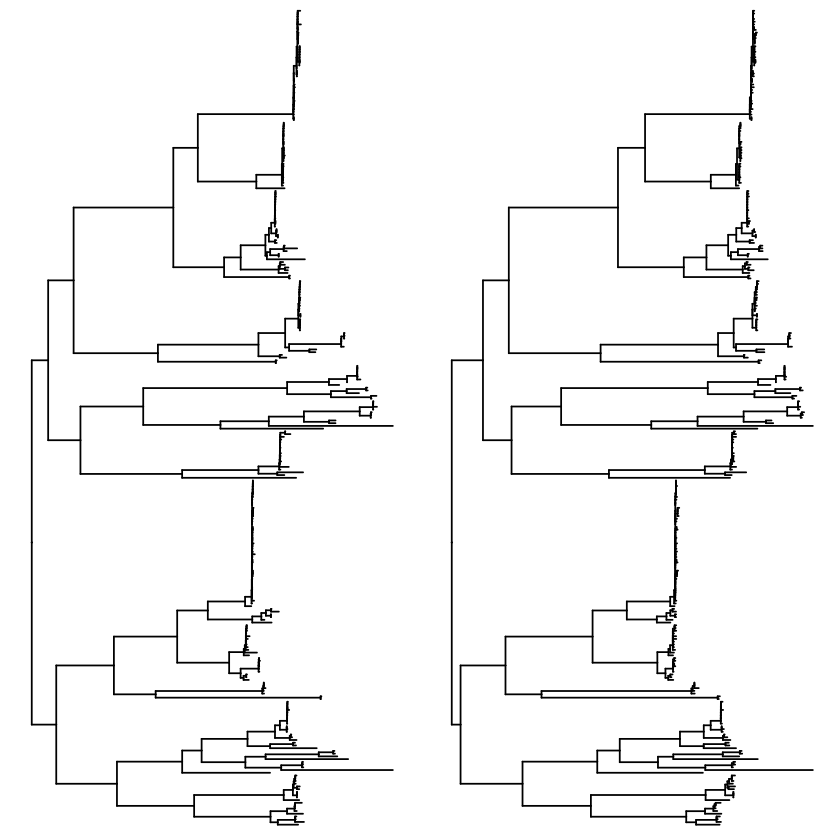

In [7]:
# generate face-to-face tree of clonalframeML tree
p1 <- ggtree(x2) %<+% metadata_extended
p2 <- ggtree(x1) %<+% metadata_extended
d1 <- p1$data
d2 <- p2$data

## reverse x-axis and 
## set offset to make the tree on the right-hand side of the first tree
d2$x <- max(d2$x) - d2$x + max(d1$x) + 1
pp <- p1 + geom_tree(data=d2)
d1 <- p1$data

dd <- bind_rows(d1, d2) %>% filter(isTip == TRUE)

f2fa <- pp + geom_line(aes(x, y, group=label, color=wgs_group), data=dd, alpha = 0.6, size = 2) #+ 
    #geom_tippoint(aes(color=wgs_group)) 
    #geom_tippoint(data=dd, aes(color=wgs_group))
#f2fa
plot_grid(p1, p2)

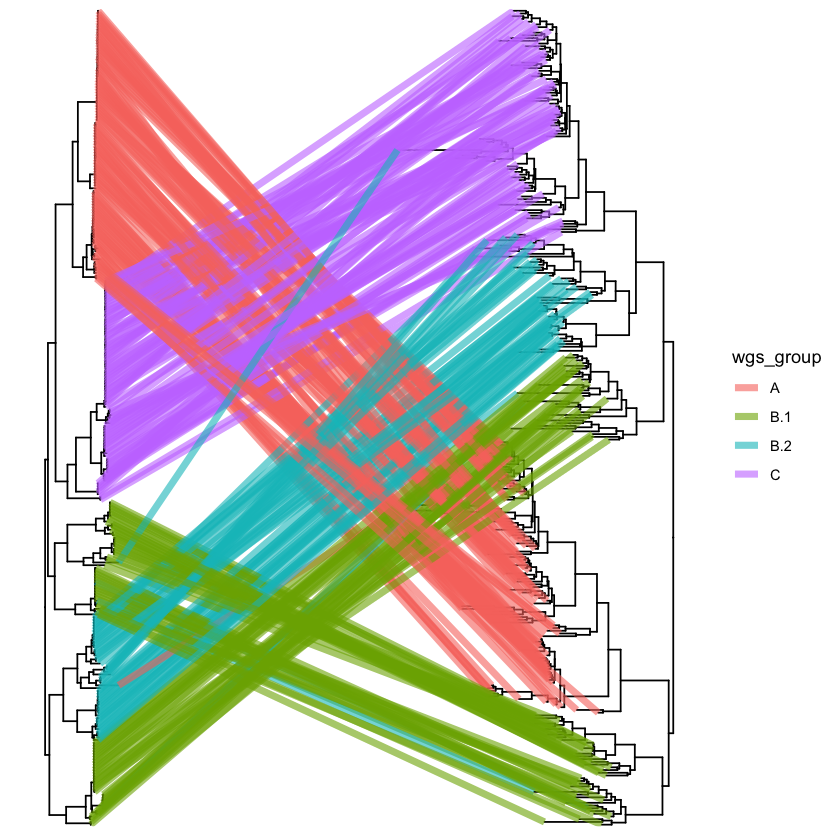

In [34]:
### Generate figure of face-to-face core and accessory tress (currently S4B)

p1 <- ggtree(x) %<+% metadata_extended
p2 <- ggtree(a) %<+% metadata_extended

d1 <- p1$data
d2 <- p2$data

## reverse x-axis and 
## set offset to make the tree on the right-hand side of the first tree
d2$x <- max(d2$x) - d2$x + max(d1$x) + 1
p1$data$x <- p1$data$x*30
pp <- p1 + geom_tree(data=d2)
d1 <- p1$data

dd <- bind_rows(d1, d2) %>% filter(isTip == TRUE)

f2f <- pp + geom_line(aes(x, y, group=label, color=wgs_group), data=dd, alpha = 0.6, size = 2) #+ 
    #geom_tippoint(aes(color=wgs_group)) 
    #geom_tippoint(data=dd, aes(color=wgs_group))
f2f
#ggsave("../results/figures/paper/Figure_S4B_core_and_accessory_genome_trees_face_to_face.jpg", height = 4, width = 4)


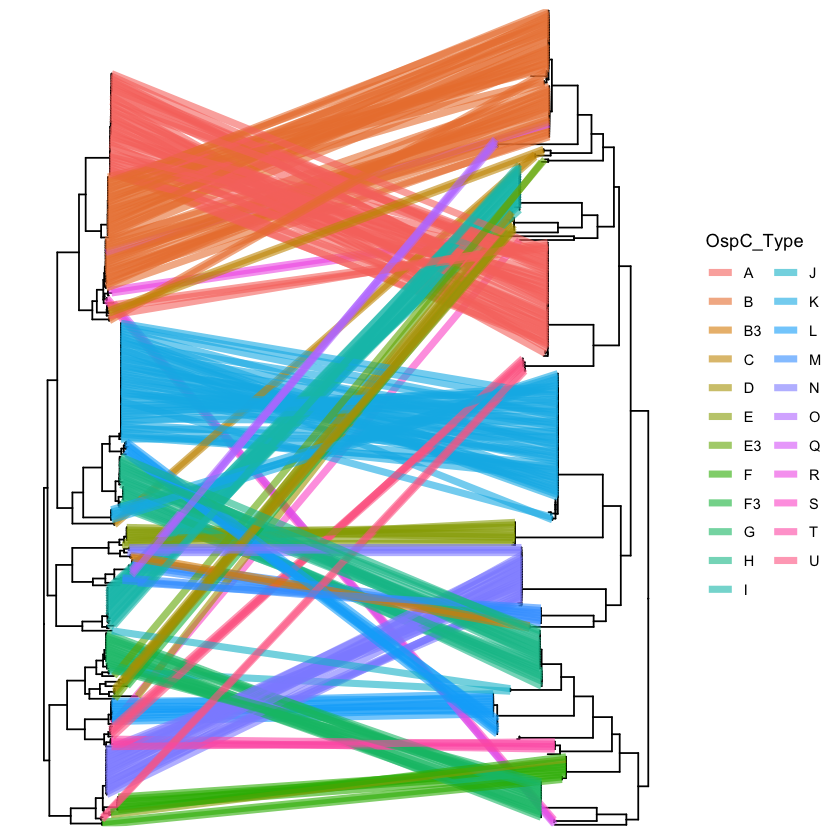

In [35]:
p1 <- ggtree(x) %<+% metadata_extended
p2 <- ggtree(y) %<+% metadata_extended

d1 <- p1$data
d2 <- p2$data

## reverse x-axis and 
## set offset to make the tree on the right-hand side of the first tree
d2$x <- max(d2$x) - d2$x + max(d1$x) + 1
p1$data$x <- p1$data$x*30
pp <- p1 + geom_tree(data=d2)
d1 <- p1$data

dd <- bind_rows(d1, d2) %>% filter(isTip == TRUE) %>% filter(!is.na(OspC_Type))
f2f2 <- pp + geom_line(aes(x, y, group=label, color=OspC_Type), data=dd, alpha = 0.6, size = 2)
f2f2

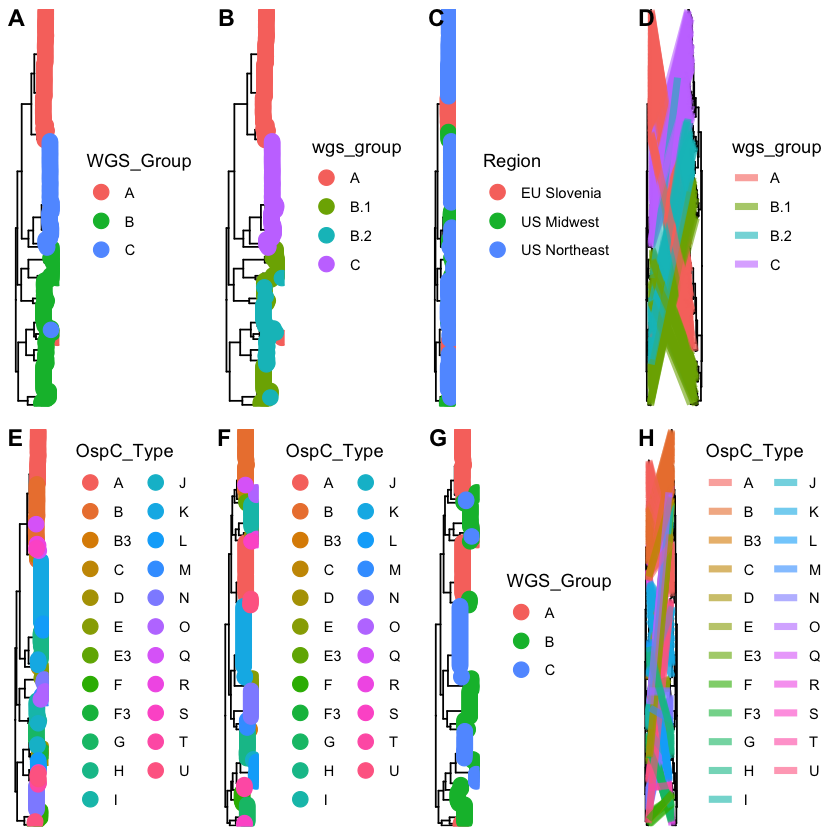

In [76]:
## Figure 2

# make wgs tree with additional annotation
wgs2_tree <- ggtree(x) %<+% metadata_extended + 
  geom_tippoint(aes(color=wgs_group, subset=!is.na(wgs_group)), size = 4)
wgs_tree_ospc <- ggtree(x) %<+% metadata + geom_tippoint(aes(color = OspC_Type), size = 4)
# make annotated accessory trees


acc_tree <- ggtree(a) %<+% metadata_extended + geom_tippoint(aes(color=WGS_Group, subset=!is.na(WGS_Group)), size = 4)
acc2_tree <- ggtree(a) %<+% metadata_extended + geom_tippoint(aes(color=wgs_group, subset=!is.na(wgs_group)), size = 4)
acc_tree_ospC <- ggtree(a) %<+% metadata_extended + geom_tippoint(aes(color=OspC_Type, subset=!is.na(OspC_Type)), size = 4)

# Make OspC tree annotated with WGS groups
ospC_tree_WGS <- ggtree(y) %<+% metadata_extended + 
  geom_tippoint(aes(color=WGS_Group, subset=!is.na(WGS_Group)), size = 4)


# assemble plot
plot_grid(wgs_tree, wgs2_tree, location_tree, f2f, wgs_tree_ospc, ospC_tree, ospC_tree_WGS, f2f2, nrow = 2, labels = c("A", "B", "C", "D", "E", "F", "G", "H"))
ggsave("../results/figures/paper/Figure_2.jpg", height = 8, width = 10)

In [ ]:
acc_tree_RST <- ggtree(a) %<+% metadata_extended + 
    geom_tippoint(aes(color=OspC_Type))
acc_tree_RST

In [ ]:
names(metadata_extended)

In [ ]:
metadata_extended %>% filter(OspC_Type == "S") %>% select(label, RST_Type, OspC_Type, wgs_group, MLST)

In [ ]:
wgs_tree + geom_tiplab(aes(label=label))
ggsave("../results/figures/paper/Figure_temp.jpg", height = 50, width = 8, limitsize=FALSE)

In [13]:
plasmid_merge <- plasmids
plasmid_merge$label <- rownames(plasmids)
plasmid_merge <- inner_join(plasmid_merge, metadata_extended)

Joining, by = "label"



In [12]:
## Conduct plasmid-specific presence/absence associations with dissemination
# this analysis uses the Pfam32 gene analysis

# create merged dataset
plasmid_merge <- plasmids
plasmid_merge$label <- rownames(plasmids)
plasmid_merge <- inner_join(plasmid_merge, metadata_extended)

# need to deal with the plasmids being hard-coded...

# conduct association tests
nplasmids <- 26
plasnames <- rep(NA, nplasmids)
pvals <- rep(NA, nplasmids)
estim <- rep(NA, nplasmids)
lowerint <- rep(NA, nplasmids)
upperint <- rep(NA, nplasmids)
for(i in c(1:11, 13:24, 26)){
    test_tmp <- fisher.test(plasmid_merge[,i], plasmid_merge$dissem_bin)
    plasnames[i] <- colnames(plasmid_merge)[i]
    pvals[i] <- test_tmp$p.value
    estim[i] <- test_tmp$estimate
    lowerint[i] <- test_tmp$conf.int[1]
    upperint[i] <- test_tmp$conf.int[2]
    #print(paste(i, test_tmp$p.value, " ", colnames(plasmid_merge)[i]))   
}
plasmid_assoc <- data.frame(plasmid = plasnames, pval = pvals, OR = estim, conflower = lowerint, confupper = upperint, logp = -1*log10(pvals),
                           adjustedP = p.adjust(pvals, method="fdr"))
plasmid_assoc <- plasmid_assoc[c(1:11, 13:24, 26),]

# parse plasmid names for plotting / output
plasmid_assoc$plasmid_name <- sapply(plasmid_assoc$plasmid, function(x) tail(strsplit(x, "_")[[1]], 1))
plasmid_assoc$plasmid_name <- gsub("ID.23.B31", "", plasmid_assoc$plasmid_name)

# generate plots of plasmid-specific ORs and a volcano plot

pOR <- plasmid_assoc %>% ggplot(aes(x = plasmid_name, y = OR)) + geom_point() + 
    geom_errorbar(aes(ymin = conflower, ymax = confupper)) + 
    coord_cartesian(ylim = c(0,5)) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90)) + 
    labs(y = "Odds Ratio of Dissemination", x = "Plasmid Name")


pVolc <- plasmid_assoc %>% ggplot(aes(x = OR, y = logp, label = plasmid_name)) + 
    geom_point(alpha = 0.3) + 
    geom_text() +
    theme_bw() + 
    labs(y = "-log10(p)", x = "Odds Ratio of Dissemination")

plot_grid(pOR, pVolc, labels = c("C", "D"))
ggsave("../results/figures/paper/Figure4C_and_D.jpg", height = 4, width = 8)

plasmid_assoc$pval_adjusted_fdr <- p.adjust(plasmid_assoc$pval, method = "fdr")
write_tsv(plasmid_assoc, "../results/tables/supplemental_data_file_6.tsv")


Joining, by = "label"



ERROR: Error in fisher.test(plasmid_merge[, i], plasmid_merge$dissem_bin): 'x' and 'y' must have at least 2 levels


Joining, by = "label"



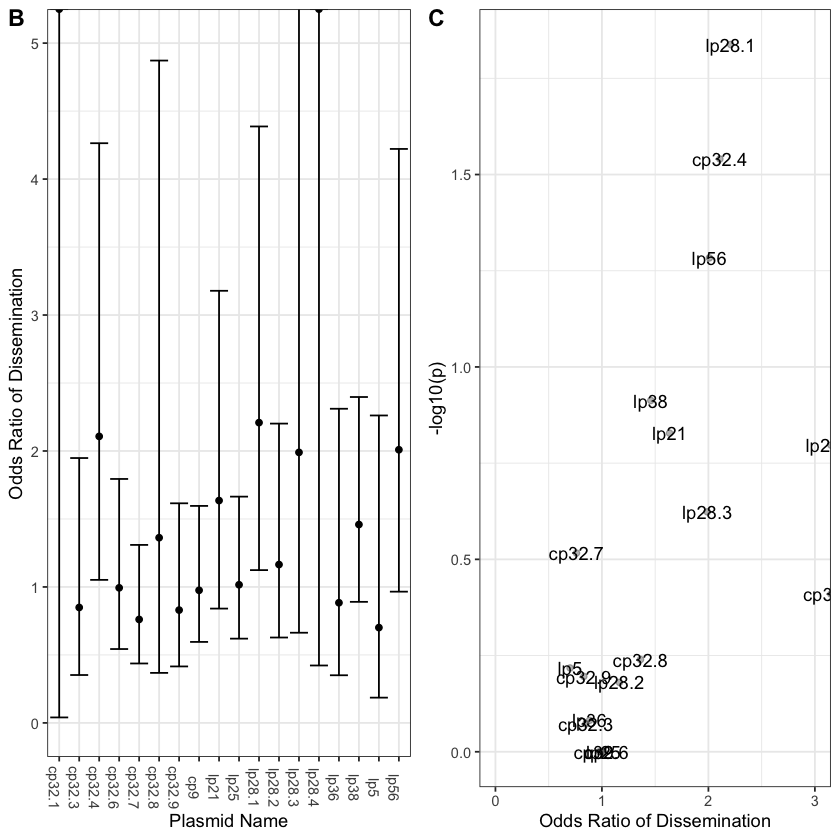

In [21]:
## Conduct plasmid-specific presence/absence associations with dissemination
# this analysis uses the B31 minimap analysis
# create merged dataset
plas2 <- data.frame(plas2)
percent_occupancy = colSums(plas2) / nrow(plas2)
plas3 <- plas2[,percent_occupancy != 1]

plasmid_merge2 <- data.frame(plas3)
plasmid_merge2$label <- rownames(plas3)
plasmid_merge2 <- inner_join(plasmid_merge2, metadata_extended)

# conduct association tests
nplasmids <- ncol(plas3)
plasnames <- rep(NA, nplasmids)
pvals <- rep(NA, nplasmids)
estim <- rep(NA, nplasmids)
lowerint <- rep(NA, nplasmids)
upperint <- rep(NA, nplasmids)
for(i in c(1:nplasmids)){
    test_tmp <- fisher.test(plasmid_merge2[,i], plasmid_merge2$dissem_bin)
    plasnames[i] <- colnames(plasmid_merge2)[i]
    pvals[i] <- test_tmp$p.value
    estim[i] <- test_tmp$estimate
    lowerint[i] <- test_tmp$conf.int[1]
    upperint[i] <- test_tmp$conf.int[2]
    #print(paste(i, test_tmp$p.value, " ", colnames(plasmid_merge)[i]))   
}
plasmid_assoc2 <- data.frame(plasmid = plasnames, pval = pvals, OR = estim, conflower = lowerint, confupper = upperint, logp = -1*log10(pvals),
                            adjustedP = p.adjust(pvals, method="fdr"))

# parse plasmid names for plotting / output
#plasmid_assoc2$plasmid_name <- sapply(plasmid_assoc$plasmid, function(x) tail(strsplit(x, "_")[[1]], 1))
#plasmid_assoc2$plasmid_name <- gsub("ID.23.B31", "", plasmid_assoc$plasmid_name)

                                     # generate plots of plasmid-specific ORs and a volcano plot

pOR2 <- plasmid_assoc2 %>% ggplot(aes(x = plasnames, y = OR)) + geom_point() + 
    geom_errorbar(aes(ymin = conflower, ymax = confupper)) + 
    coord_cartesian(ylim = c(0,5)) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90)) + 
    labs(y = "Odds Ratio of Dissemination", x = "Plasmid Name")


pVolc2 <- plasmid_assoc2 %>% ggplot(aes(x = OR, y = logp, label = plasnames)) + 
    geom_point(alpha = 0.3) + 
    geom_text() +
    theme_bw() + 
    labs(y = "-log10(p)", x = "Odds Ratio of Dissemination") + 
    coord_cartesian(xlim = c(0,3))

plot_grid(pOR2, pVolc2, labels = c("B", "C"))
ggsave("../results/figures/paper/Figure_S5B_C.jpg", height = 4, width = 8)

plasmid_assoc2$pval_adjusted_fdr <- p.adjust(plasmid_assoc2$pval, method = "fdr")
write_tsv(plasmid_assoc2, "../results/tables/supplemental_data_file_7.tsv")


In [67]:
gt_merge <- data.frame(t(gt.annot))
gt_merge <- gt_merge[,colSums(gt_merge) < 297 & colSums(gt_merge) > 1]
ngenes <- ncol(gt_merge)
gt_merge$label <- rownames(gt_merge)
gt_merge <- inner_join(gt_merge, metadata_extended)

Joining, by = "label"



In [68]:
gene_p <- rep(NA, ngenes)
gene_eff <- rep(NA, ngenes)
l_int <- rep(NA, ngenes)
u_int <- rep(NA, ngenes)
for(i in 1:ngenes){
    test_stat <- fisher.test(gt_merge[,i], gt_merge$dissem_bin)
    gene_p[i] <- test_stat$p.value
    gene_eff[i] <- test_stat$estimate
    l_int[i] <- test_stat$conf.int[1]
    u_int[i] <- test_stat$conf.int[2]
}

In [77]:
gene_assoc <- data.frame(gene = colnames(gt_merge)[1:ngenes], pval = gene_p, OR = gene_eff, logp = -1*log10(gene_p), conf_lower = l_int, conf_upper = u_int,
                        adjustedP = p.adjust(gene_p, method="fdr")) %>%
    mutate(Annotation = str_split_fixed(gene, "\\.", 2)[,1], groupID = sapply(gene, function(x) tail(strsplit(x, "\\.")[[1]],1))) %>% mutate(ortho = paste(groupID, Annotation, sep="-")) %>% 
    mutate(desc = gsub("Borrelia\\.burgdorferi", "", gene)) %>% mutate(desc = gsub("\\.", " ", desc))

In [70]:
annot2 <- annot %>% rename(Gene = "groupID", Locus = "Annotation") %>% mutate(ortho = paste(groupID, Annotation, sep="-"))

In [77]:
gene_assoc2 <- left_join(gene_assoc, annot2, by = c("ortho"))

Warning message:
“Transformation introduced infinite values in continuous x-axis”


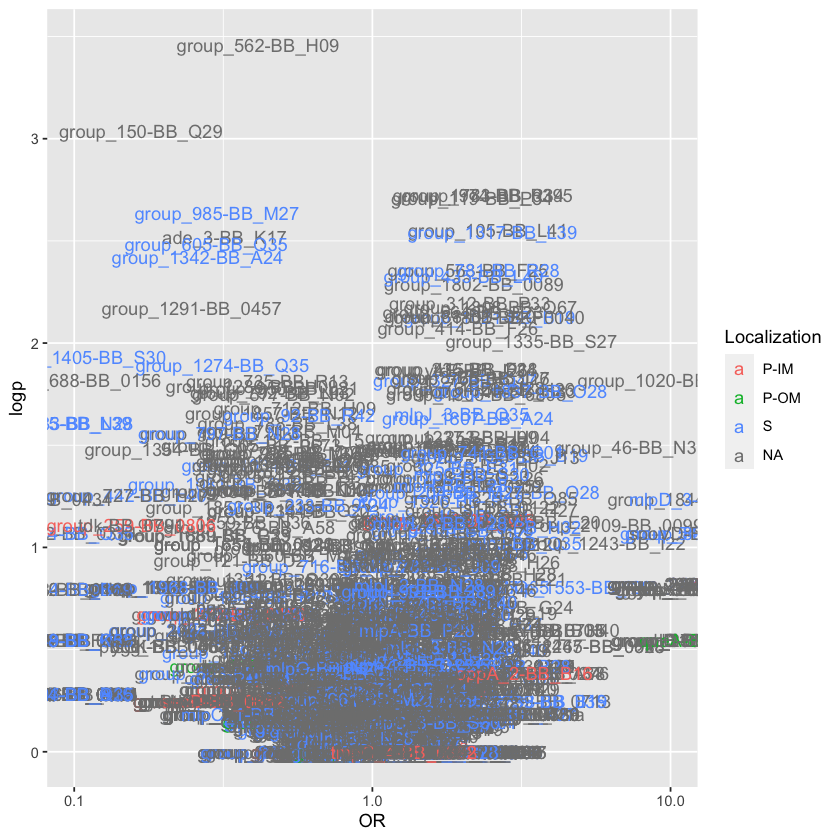

In [95]:
gene_assoc2 %>% ggplot(aes(x = OR, y = logp, label = ortho, color = Localization)) + geom_text() + scale_x_log10()

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


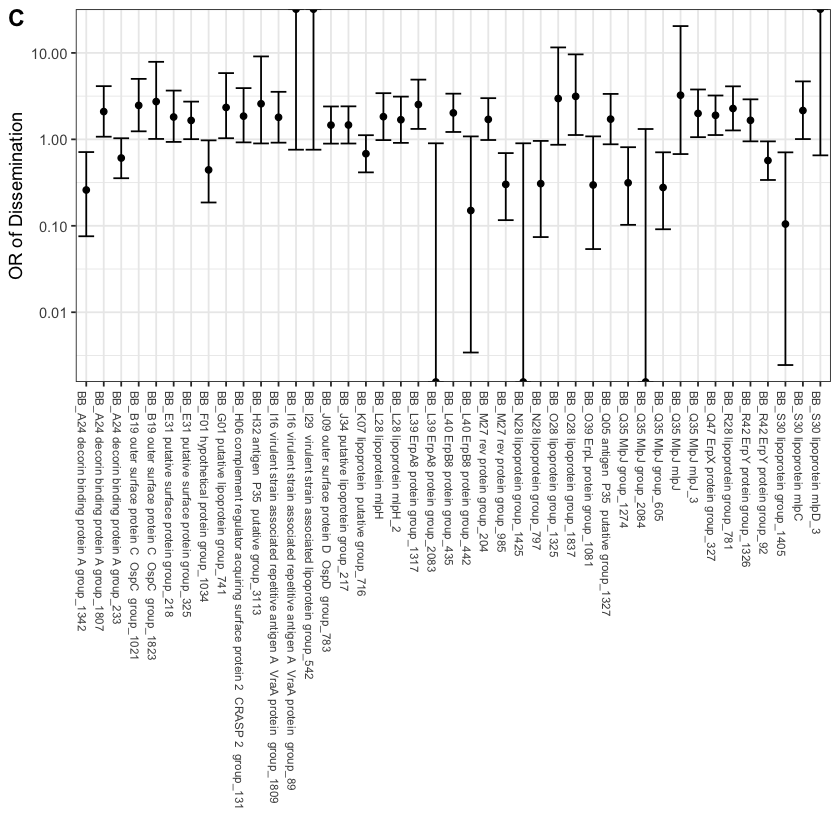

In [94]:
## Figure 5C

pGAS <- gene_assoc2 %>% filter(Localization == "S", pval < 0.15) %>% ggplot(aes( x = desc, y = OR)) + geom_point() + geom_errorbar(aes(ymin = conf_lower, ymax = conf_upper)) + theme_bw() + #coord_cartesian(ylim = c(0,5)) + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0, size = 7)) + scale_y_log10() + labs(x = "", y = "OR of Dissemination")
plot_grid(pGAS, labels = c("C"))
ggsave("../results/figures/paper/Figure5C.jpg", height = 6, width = 8)

In [50]:
gene_assoc2

gene                                                                                                   
1    BB_0622.acetate.kinase.ackA                                                                            
2    BB_H33.adenine.deaminase..Adenase...Adenine.aminase..ade_1                                             
3    BB_K17.adenine.deaminase.ade_2                                                                         
4    BB_K17.adenine.deaminase.ade_3                                                                         
5    BB_B23.putative.guanine.xanthine.permease.adeP                                                         
6    BB_0417.adenylate.kinase..ATP.AMP.transphosphorylase...AK..Superoxide.inducible.protein.16...SOI16..adk
7    BB_0160.alanine.racemase.alr1                                                                          
8    BB_0572.glycosyl.transferase.arnC                                                                      
9    BB_0831.xylose.operon.regulatory.protein.bglK                                                          
10   BB_0754.ABC.transporter..ATP.binding.protein.btuD_1                                                    
11   BB_0146.glycine.betaine..L.proline.ABC.transporter..ATP.binding.protein.btuD_2                         
12   BB_0706.polynucleotide.adenylyltransferase.cca                                                         
13   BB_0618.cytidine.deaminase.cdd                                                                         
14   BB_0040.CheR.methyltransferase..SAM.binding.domain.cheR                                                
15   BB_0414.chemotaxis.protein.methyltransferase.cheR1                                                     
16   BB_0672.CheY.cheY_2                                                                                    
17   BB_0812.phosphopantothenoylcysteine.decarboxylase.phosphopantothenate..cysteine.ligase.coaBC           
18   BB_0702.pantetheine.phosphate.adenylyltransferase.coaD                                                 
19   BB_0547.dephospho.CoA.kinase.coaE                                                                      
20   BB_0527.transcriptional.activator..putative..Baf.family.coaX                                           
21   BB_0591.competence.locus.E..putative.comEC                                                             
22   BB_0084.aminotransferase..class.V.superfamily.csd                                                      
23   BB_0524.Inositol.monophosphatase.family.protein.cysQ                                                   
24   BB_A24.decorin.binding.protein.A.dbpA                                                                  
25   BB_0200.D.alanine..D.alanine.ligase..D.alanylalanine.synthetase..D.Ala.D.Ala.ligase..ddl               
26   BB_0508.ribosome.associated.GTPase.EngA.der                                                            
27   BB_0301.DivIB.divIB                                                                                    
28   BB_G32.putative.replicative.helicase.dnaB_2                                                            
29   BB_0579.DNA.polymerase.III.subunit.alpha.dnaE                                                          
30   BB_0737.histidine.phosphokinase.phophatase..putative.dus                                               
⋮    ⋮                                                                                                      
1142 BB_0434.stage.0.sporulation.protein.J.spo0J                                                            
1143 BB_0136.penicillin.binding.protein.spoVD                                                               
1144 BB_0729.transporter..dicarboxylate.amino.acid.cation..na..or.H...symporter..daacs..family.tcyP         
1145 BB_0791.thymidine.kinase.tdk                                                                           
1146 BB_A76.thymidylate.synthase..flavin.dependent.thyX                          

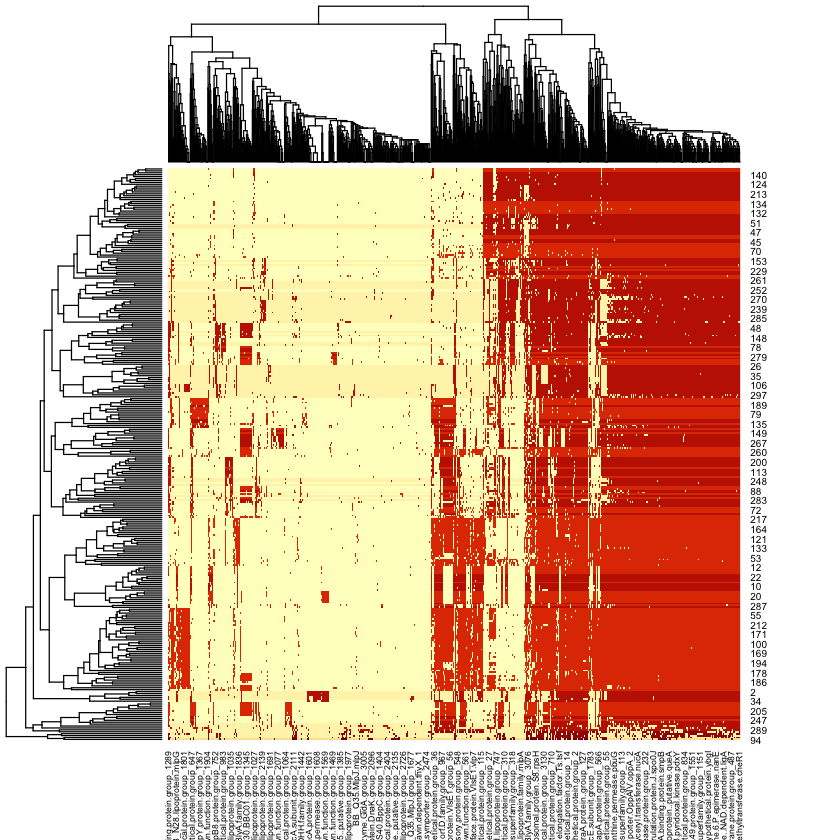

In [79]:
heatmap(as.matrix(gt_merge[,1:ngenes]))

In [98]:
gene_assoc[grep("ecorin", gene_assoc$gene),]

gene                                        pval        OR       
24  BB_A24.decorin.binding.protein.A.dbpA       0.180321975 1.4106135
204 BB_A24.decorin.binding.protein.A.group_1342 0.003768824 0.2595831
229 BB_A24.decorin.binding.protein.A.group_1381 0.156093190 0.2182327
432 BB_A24.decorin.binding.protein.A.group_1807 0.023287450 2.0955535
520 BB_A24.decorin.binding.protein.A.group_2029 1.000000000 0.7832416
599 BB_A24.decorin.binding.protein.A.group_233  0.061965301 0.6084440
    logp         annotation Gene ID Locus B31_Annotation Localization
24  7.439513e-01 BB_A24     NA   NA NA    NA             NA          
204 2.423794e+00 BB_A24     NA   NA NA    NA             NA          
229 8.066160e-01 BB_A24     NA   NA NA    NA             NA          
432 1.632878e+00 BB_A24     NA   NA NA    NA             NA          
520 4.821637e-17 BB_A24     NA   NA NA    NA             NA          
599 1.207851e+00 BB_A24     NA   NA NA    NA             NA

In [86]:
annot[ grep("ecorin", annot$gene) , ]

Gene       ID             Locus  B31_Annotation            Localization
1 dbpB       CCPCLGGI_00893 BB_A25 decorin-binding protein B NA          
2 group_233  CCPCLGGI_00894 BB_A24 decorin-binding protein A S           
3 dbpA       DCJNHIBD_00893 BB_A24 decorin-binding protein A S           
4 group_1807 OANOCMKI_00895 BB_A24 decorin-binding protein A S           
5 group_1342 JAEJLJHM_00901 BB_A24 decorin-binding protein A S           
6 group_1381 KGAMKNHC_00943 BB_A24 decorin-binding protein A S           
7 group_2029 MKCMKCOD_00886 BB_A24 decorin-binding protein A S           
  label                                      
1 BB_A25.decorin-binding protein B.dbpB      
2 BB_A24.decorin-binding protein A.group_233 
3 BB_A24.decorin-binding protein A.dbpA      
4 BB_A24.decorin-binding protein A.group_1807
5 BB_A24.decorin-binding protein A.group_1342
6 BB_A24.decorin-binding protein A.group_1381
7 BB_A24.decorin-binding protein A.group_2029
  gene                                       
1 BB_A25.decorin-binding protein B.dbpB      
2 BB_A24.decorin-binding protein A.group_233 
3 BB_A24.decorin-binding protein A.dbpA      
4 BB_A24.decorin-binding protein A.group_1807
5 BB_A24.decorin-binding protein A.group_1342
6 BB_A24.decorin-binding protein A.group_1381
7 BB_A24.decorin-binding protein A.group_2029

In [96]:
seer <- read_csv("../results/roary-results/supplemental_data_file_1.csv")

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  group = col_character(),
  lineage = col_character(),
  notes = col_character(),
  ID = col_character(),
  Group = col_character(),
  Locus = col_character(),
  B31_Annotation = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [97]:
head(seer)

X1   group      af     filter-pvalue lrt-pvalue beta  beta-std-err intercept
1  210 group_688  0.9770 0.0102        0.000861   -2.79 7.910         2.230   
2  541 group_575  0.4430 0.0450        0.001420   -1.52 0.518         0.154   
3  330 group_1505 0.9160 0.0240        0.001820   -1.47 0.486         0.828   
4  430 group_566  0.6510 0.5360        0.002150   -1.38 0.483         0.361   
5  466 group_42   0.5300 0.2840        0.002430   -1.80 0.662         0.412   
6 1131 group_1020 0.0235 0.0102        0.006560    2.26 1.000        -0.531   
  PC1    PC2    ⋯ PC9     PC10  lineage notes     -log10 P Unnamed: 0
1 -0.722 -0.290 ⋯  0.0980 0.223 MDS10   bad-chisq 3.064997  662      
2 -1.010  0.448 ⋯  0.1250 0.400 MDS2    NA        2.847712 1340      
3 -0.743 -0.310 ⋯  0.1160 0.129 MDS10   NA        2.739929  166      
4 -1.140 -0.292 ⋯ -0.1320 0.223 MDS8    NA        2.667562 1284      
5 -1.170  0.562 ⋯  0.0381 0.369 NA      NA        2.614394 1561      
6 -0.634 -0.262 ⋯  0.1780 0.250 MDS10   bad-chisq 2.183096 1648      
  ID             Group      Locus   B31_Annotation                
1 CCPCLGGI_00700 group_688  BB_0156 conserved hypothetical protein
2 OJICOLNA_01010 group_575  BB_0372 glutamyl-tRNA synthetase      
3 CCPCLGGI_00176 group_1505 BB_0673 conserved hypothetical protein
4 PFDKALEN_01266 group_566  BB_S42  BapA protein                  
5 DCJNHIBD_01184 group_42   BB_O15  conserved hypothetical protein
6 FAKOJBMH_01308 group_1020 BB_0192 conserved hypothetical protein

In [98]:
ga3 <- gene_assoc2 %>% select(groupID.x, pval, OR) %>% rename(groupID.x = "group")

In [99]:
head(ga3)

group pval        OR       
1 ackA  0.437122098 0.4705081
2 ade_1 0.265652223 1.8851507
3 ade_2 1.000000000 1.2767452
4 ade_3 0.003014371 0.3198167
5 adeP  0.649269294 1.2965157
6 adk   0.348512424 0.5190701

In [100]:
dim(ga3)

[1] 1171    3

In [101]:
dim(seer)

[1] 1326   26

In [102]:
ga3 <- left_join(ga3, seer)

Joining, by = "group"



Warning message:
“Removed 97 rows containing missing values (geom_point).”


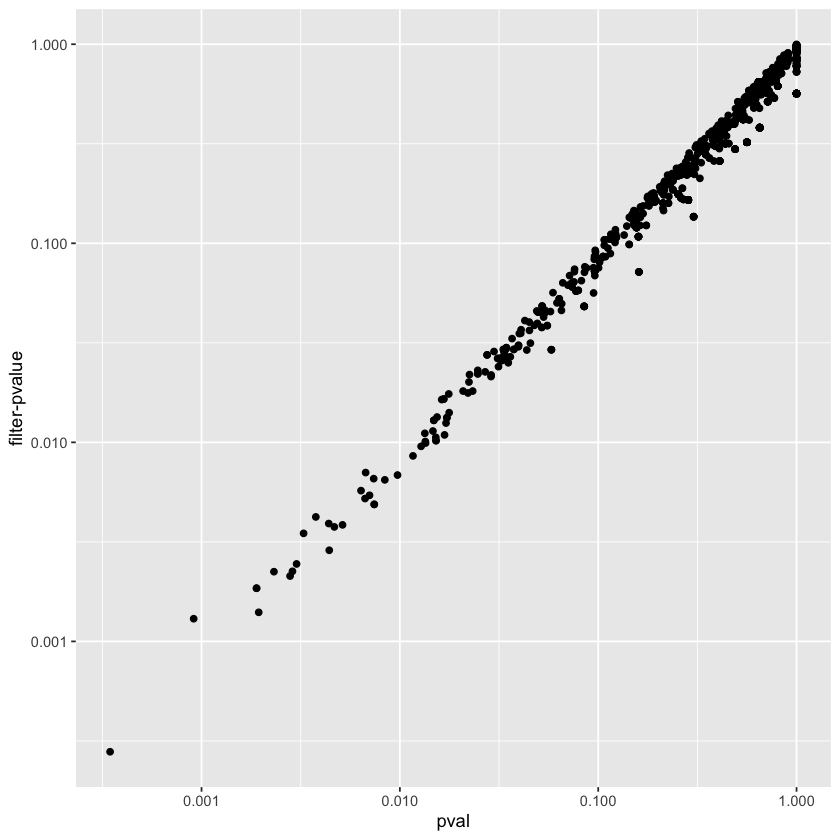

In [131]:
ga3 %>% ggplot(aes(x = pval, y = `filter-pvalue`, label = B31_Annotation)) + geom_point() + scale_x_log10() + scale_y_log10()

Warning message:
“Removed 97 rows containing missing values (geom_text).”


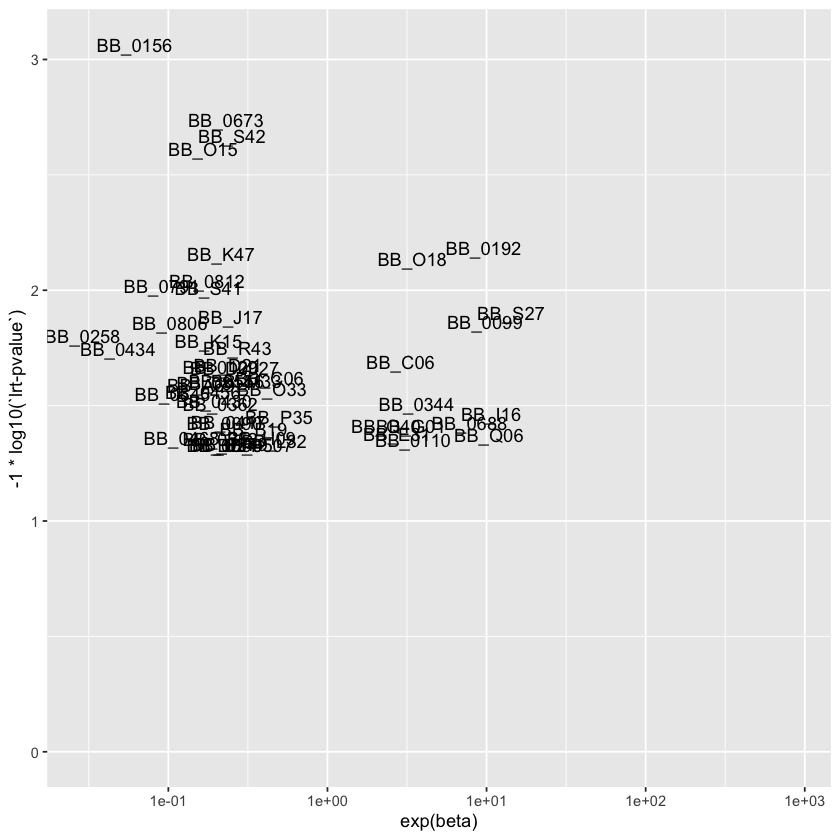

In [140]:
ga3 %>% #filter(af > 0.05 & af < 0.95) %>% 
    mutate(sublabel = ifelse(`lrt-pvalue` < 0.05, Locus, "")) %>%
    ggplot(aes(y = -1*log10(`lrt-pvalue`), x = exp(beta), label = sublabel)) + geom_text() + scale_x_log10()

In [138]:
names(ga3)

[1] "group"          "pval"           "OR"             "X1"            
 [5] "af"             "filter-pvalue"  "lrt-pvalue"     "beta"          
 [9] "beta-std-err"   "intercept"      "PC1"            "PC2"           
[13] "PC3"            "PC4"            "PC5"            "PC6"           
[17] "PC7"            "PC8"            "PC9"            "PC10"          
[21] "lineage"        "notes"          "-log10 P"       "Unnamed: 0"    
[25] "ID"             "Group"          "Locus"          "B31_Annotation"

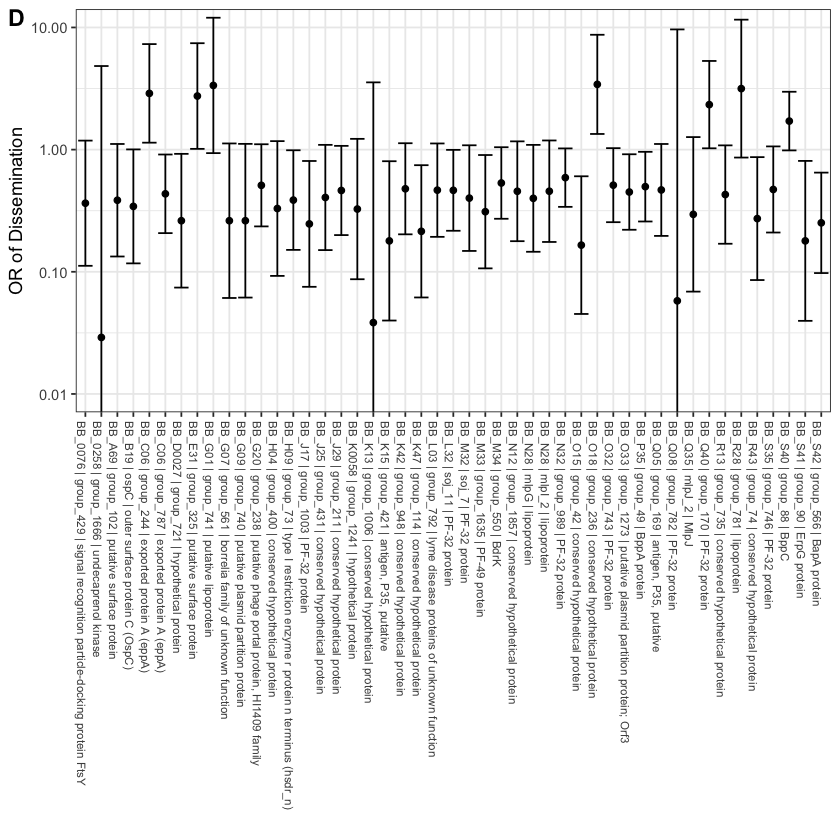

In [161]:
pga3 <- ga3 %>% filter(`lrt-pvalue` < 0.1) %>% filter(af > 0.1 & af < 0.9) %>% 
    ggplot(aes( x = paste(Locus, Group, B31_Annotation, sep=" | "), y = exp(beta))) + geom_point() + geom_errorbar(aes(ymin = exp(beta - 1.96*`beta-std-err`), ymax = exp(beta + 1.96*`beta-std-err`))) + theme_bw() + coord_cartesian(ylim = c(0.01,10)) + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0, size = 7)) + scale_y_log10() + labs(x = "", y = "OR of Dissemination")
plot_grid(pga3, labels = c("D"))
ggsave("../results/figures/paper/Figure7D.jpg", height = 6, width = 8)

New names:
* Source...10 -> Source...18
* Species...37 -> Species...45
* Source...43 -> Source...51
* Species...46 -> Species...54

New names:
* Source...10 -> Source...28
* Species...37 -> Species...55
* Source...43 -> Source...61
* Species...46 -> Species...64



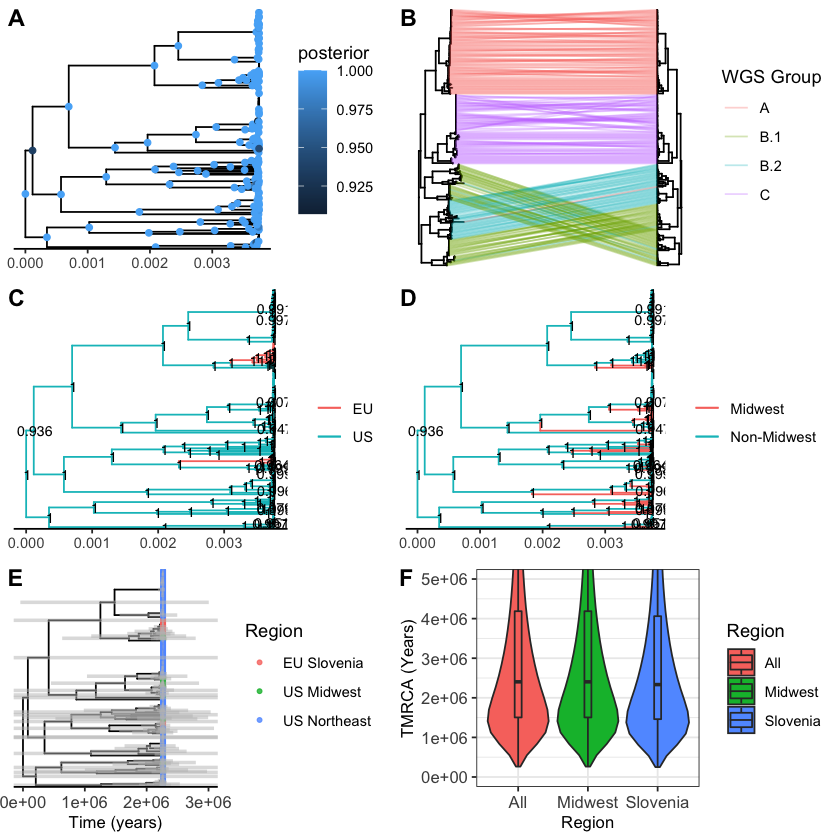

In [77]:
## compare MCC and ML trees
b <- read.beast("../results/BEAST/no_dates_ancestral_geography/core_gene_alignment.aln.mcc.tree")

beast_tree <- ggtree(b) %<+% metadata_extended + 
    #geom_nodelab(aes(label = round(posterior, 3), subset = posterior > 0.9), size = 3) + 
    geom_nodepoint(aes(color = posterior, subset = posterior > 0.9)) + 
    theme_tree2()

p1 <- ggtree(x) %<+% metadata_extended
p2 <- ggtree(b) %<+% metadata_extended

d1 <- p1$data
d2 <- p2$data

## reverse x-axis and 
## set offset to make the tree on the right-hand side of the first tree

p1$data$x <- p1$data$x
d2$x <- max(d2$x) - d2$x + max(d1$x) + 0.03
pp <- p1 + geom_tree(data=d2)
d1 <- p1$data

dd <- bind_rows(d1, d2) %>% filter(isTip == TRUE) %>% filter(!is.na(OspC_Type))
f2f3 <- pp + geom_line(aes(x, y, group=label, color=wgs_group), data=dd, alpha = 0.3) +  
    scale_color_discrete(name = "WGS Group")
US <- list(US = metadata_extended$label[metadata_extended$Region == "US Northeast" | metadata_extended$Region == "US Midwest"])
Midwest <- list(US = metadata_extended$label[metadata_extended$Region == "US Northeast" | metadata_extended$Region == "EU Slovenia"])
eu_tree <- groupOTU(b,  US)
mw_tree <- groupOTU(b, Midwest)

eu <- ggtree(eu_tree, aes(color = group)) + 
    scale_color_discrete(labels = c("EU", "US"), name = "") + 
    geom_nodelab(aes(label = round(posterior, 3), subset = posterior > 0.9), color = "black", size = 3) + 
    theme_tree2()

mw <- ggtree(mw_tree, aes(color = group)) + 
    geom_nodelab(aes(label = round(posterior, 3), subset = posterior > 0.9), color = "black" ,size = 3) + 
    scale_color_discrete(labels = c("Midwest", "Non-Midwest"), name = "") + 
    theme_tree2()

## compare MCC and ML trees


b2 <- read.beast("../results/BEAST/GTRG_constant_pop_gamma_dist_100M/mcc.tree")
metadata_extended2 <- metadata_extended %>%
    mutate(label = paste(label, Location, Year, sep= "|"))
beast_tree2 <- ggtree(b2) %<+% metadata_extended2 + 
    #geom_nodelab(aes(label = round(posterior, 3), subset = posterior > 0.9), size = 3) + 
    #geom_nodepoint(aes(color = posterior, subset = posterior > 0.9)) + 
    geom_tippoint(aes(color=Region, subset=!is.na(Region)), size = 1, alpha = 0.8) + 
    theme_tree2() + 
    geom_range(range='height_0.95_HPD', color='gray', alpha=.5, size=1) + 
    coord_cartesian(x = c(0, 3000000)) + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10)) +
    labs(x = "Time (years)")

beast_trace <- readLog("../results/BEAST/GTRG_constant_pop_gamma_dist_100M/core_gene_alignment_BEAST.aln.log", burnin = 0.2)
bt <- data.frame(beast_trace)
bt$iteration <- rownames(bt)
bt <- bt[,c("iteration","treeModel.rootHeight", "tmrca.Slovenia.", "tmrca.Midwest.")]
names(bt) <- c("iteration", "All", "Slovenia", "Midwest")
bt_reshaped <- pivot_longer(bt, cols=-c(iteration), names_to = "Region", values_to = "TMRCA")

beast_tmrca <- ggplot(bt_reshaped, aes(x = Region, y = TMRCA, fill = Region)) + 
    geom_violin() + coord_cartesian(y = c(0, 5e6)) + 
    geom_boxplot(width = 0.1) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10)) + 
    labs(y = "TMRCA (Years)")

plot_grid(beast_tree, f2f3, eu, mw, beast_tree2, beast_tmrca, labels = c("A", "B", "C", "D", "E", "F"), rel_widths = c(1.75,2), nrow = 3)
ggsave("../results/figures/paper/Figure_S2A-F.jpg", height = 10, width = 8)